<h1>E-Commerce Actual Data Transactions from UK Retailer</h1>
<br>
In this notebook we are going to explore an <a href='https://archive.ics.uci.edu/ml/datasets/Online+Retail'>e-commerce dataset transactions from an UK retailer</a>, this dataset lists purchases made by approximately 40000 customers through a period of time of one year <i>(from 12/01/2010 to 12/09/2011)</i>. The main aim of this notebook is to develop a machine learning model that allows to anticipate the purhcases that will be made by a new customer, over the next year according to its firsts purchases.
<br>
<br>
This notebooks is divided by the following steps:
<ul>
    <li>Data Cleaning.</li>
    <li>Feature Exploration.</li>
    <li>Understanding Product Categories.</li>
    <li>Customers Categories.</li>
    <li>Classifying Customers.</li>
    <li>Testing Predictions.</li>
    <li>Explaining The Decissions of The Model.</li>
</ul>

<h2>Importing Necessary Packages, Modules and Libraries</h2>

In [162]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve, KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

<h2>Data Cleaning</h2>
<br>
Let's load the dataset into memory! with <code>encoding</code> parameter and the value of <code>ISO-8859-1</code> will allows us to be able to read the dataset, for a better understanding of this parameter and its value, check the next links:
<ul>
    <li><code>encoding</code>: <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html'>Pandas official docs for <code>read_csv</a> method.</li>
    <li><code>ISO-8859-1</code>: <a href=''>Codec registry and base classes</a>.</li>
</ul>
with <code>dtype</code> parameter by using a dictionary we convert into <code>string</code> variables the columns <code>CustomerID</code> and <code>InvoiceID</code>.

In [2]:
df = pd.read_csv('ecommerce-data/data.csv', encoding='ISO-8859-1', dtype={'CustomerID': str, 'InvoiceID': str})

Now with the data in memory, let's take a look a its dimensions.

In [3]:
df.shape

(541909, 8)

<b>541909</b> rows and <b>8</b> columns! Let's see general information of this dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Looks like there are null values, missing values. We must clean up this dataset!
<br>
<br>
Let's create a variable <code>columns_info</code> that will hold the data types of every column in the dataset. This is done by creating a <code>DataFrame</code> object that has information the types of the columns that the dataset <code>df</code> holds, this is obtained by passing <code>df.dtypes</code> as parameter for the dataset, then with the function <code>T</code> we <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.T.html'>transposed</a> our dataset and by renaming with the function <code>rename</code> we give a name to the new columns

In [5]:
columns_info= pd.DataFrame(df.dtypes).T.rename(index={0: 'Column Type'})

Looking for how many nulls we have in every single column of this dataset.
<br>
<br>
We append to <codde>columns_info</code> another <i>row in the index column</i>, called <code>Null Values (NV)</code>, this new row will hold the amount of null values for every column in the dataset, this is done thanks to <code>df.isnull().sum()</code> that is passed as the value for the parameter <code>data</code> in the constructor of <code>DataFrame</code>.

In [6]:
columns_info = columns_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values (NV)'}))

<b>How much do these null values composed the dataset?</b>
<br>
<br>
Again by appending to <code>columns_info</code> another <i>row in the index column</i>, called <code>Null Values (%)</code>, this new row will hold the <b>percentage</b> of null values for every column in the dataset, this is done thanks to <code>df.isnull().sum()/df.shape[0]*100</code> that is passed as the value for the parameter data in the constructor of <code>DataFrame</code>.
<br>
<br>
<b>Explaining the operation</b> <code>df.isnull().sum()/df.shape[0]*100</code>:
<br>
With <code>df.isnull().sum()</code> we get the total amount of null values in every column and then by dividing for the number of rows gotten from <code>df.shape[0]</code> we multiply by <code>100</code> to known how much percentage these null values represent in the dataset.

In [7]:
columns_info=columns_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values (%)'}))

Let's take a look at <code>columns_info</code>:

In [8]:
columns_info

InvoiceNo StockCode Description Quantity InvoiceDate  \
Column Type         object    object      object    int64      object   
Null Values (NV)         0         0        1454        0           0   
Null Values (%)          0         0    0.268311        0           0   

                 UnitPrice CustomerID Country  
Column Type        float64     object  object  
Null Values (NV)         0     135080       0  
Null Values (%)          0    24.9267       0

There are null values in the columns <code>Description</code> and <code>CustomerID</code>, these null values represent a <b>0.26%</b> and <b>24.9267%</b> respectively.
<br>
<br>
Let's see a random sample from the dataset:

In [9]:
df.sample(5)

InvoiceNo StockCode                      Description  Quantity  \
383507    570027     21668   RED STRIPE CERAMIC DRAWER KNOB        12   
317170    564758     22269          EGG CUP NATURAL CHICKEN         1   
421358    572946     23460            SWEETHEART WALL TIDY          2   
284751    561885     21849  SILVER DIAMANTE PEN IN GIFT BOX         2   
128739    547359    85099B          JUMBO BAG RED RETROSPOT        14   

             InvoiceDate  UnitPrice CustomerID         Country  
383507   10/7/2011 10:41       1.45      14844  United Kingdom  
317170   8/30/2011 10:39       0.83        NaN  United Kingdom  
421358  10/27/2011 10:36       9.95      13988  United Kingdom  
284751   7/31/2011 13:13       4.95      15532  United Kingdom  
128739   3/22/2011 12:27       1.95      15719  United Kingdom

Now we know that almost <b>25%</b> of the transactions are not assigned to a particular client and arround <b>0.27%</b> of the transactions descriptions are not specified, there are several ways to deal with missing values:
<ul>
    <li>Impute values for the <code>CustomerID</code> and <code>Description</code>, in this case it is impossible, does not 
        make sense. </li>
    <li>Apply clustering analysis and see patterns in those <i>unknown</i> clients and <i>unknown</i> description of 
        products. Once these patterns are detected we can assign a labels for them and use these labels as a generic 
        <i>CustomerID</i> and <i>Description</i>.</li>
    <li>Delete the rows where these missing values are found.</li>
<ul>

For simplicity we'll delete the missing values with the method <code>dropna()</code>, understanding its parameters:
<ul>
    <li><code>axis</code>: with the value of <code>0</code> to specify that we are interested in the missing <i>rows</i>.
    </li>
    <li><code>subset</code>: The name of the column, where the missing values.</li>
    <li><code>inplace</code>: To return a new dataset that does not have missing values.</li>
</ul>

In [10]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

We have cleaned the dataset from missing values! Once again by using the same methods as we did to know how many null values were in the dataset and how much they composed the dataset, we take a look to check up if these values were deleted from the dataset.

In [11]:
columns_info=pd.DataFrame(df.dtypes).T.rename(index={0:'Column Type'})
columns_info=columns_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values (NB)'}))
columns_info=columns_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values (%)'}))

The methods have been applied, now let's see the information:

In [12]:
columns_info

InvoiceNo StockCode Description Quantity InvoiceDate  \
Column Type         object    object      object    int64      object   
Null Values (NB)         0         0           0        0           0   
Null Values (%)          0         0           0        0           0   

                 UnitPrice CustomerID Country  
Column Type        float64     object  object  
Null Values (NB)         0          0       0  
Null Values (%)          0          0       0

Nice! The missing values were deleted from the dataset. Now what are we going to do is to check for duplicated values, <i>duplicate values can cause generalization problems, duplicated values can biased the model.</i> This check is done the next way.

In [13]:
print('Quantity of duplicate values: {}'.format(df.duplicated().sum()))

Quantity of duplicate values: 5225


There are <b>5225</b> duplicated values, let's take a look at some of them.
<br>
First we get the indexes of 5 random duplicated values, these indexes are going to be hold in the <code>indexex</code> var, then with the <code>loc[]</code> function we found to print them.

In [14]:
indexes = df.duplicated().sample(5).index
print('Samples of duplicate values:\n{}'.format(df.loc[indexes]))

Samples of duplicate values:
       InvoiceNo StockCode                        Description  Quantity  \
77682     542777     22487     WHITE WOOD GARDEN PLANT LADDER         4   
242142    558315     37500        TEA TIME TEAPOT IN GIFT BOX        12   
483243    577497     23564            EGG CUP MILKMAID INGRID         1   
516776   C579948     21730  GLASS STAR FROSTED T-LIGHT HOLDER        -1   
342375    566860    84029E     RED WOOLLY HOTTIE WHITE HEART.        12   

             InvoiceDate  UnitPrice CustomerID         Country  
77682      2/1/2011 8:31       8.50      14911            EIRE  
242142   6/28/2011 11:44       4.95      15065  United Kingdom  
483243  11/20/2011 12:22       1.25      17555  United Kingdom  
516776   12/1/2011 10:56       4.95      16376  United Kingdom  
342375   9/15/2011 12:40       4.25      17002  United Kingdom  


Cool! Time to drop them from the dataset, with the funciton <code>drop_duplicates</code> and the value <code>True</code> for the parameter <code>inplace</code>, this wo need won't need to assign back to the <code>df</code> dataframe, because it is on the same copy.


In [15]:
df.drop_duplicates(inplace=True)

We have finished with cleaning the dataset, now we are going to work on <b>Feature Exploration</b> to <i>have a view and a opinion over the columns that the dataset is made of.</i>
<br>
<h2>Feature Exploration</h2>
<br>
In the <a href='https://archive.ics.uci.edu/ml/datasets/Online+Retail'>UCl Machine Learning Repository</a> we can find the explanation of every column, I'll list their explanation below:
<ul>
    <li><code>InvoiceNo</code>: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. 
        If this code starts with letter <b>'c'</b>, it indicates a cancellation.</li>
    <li><code>StockCode</code>: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct 
        product.</li>
    <li><code>Description</code>: Product (item) name. Nominal.</li>
    <li><code>Quantity</code>: The quantities of each product (item) per transaction. Numeric.</li>
    <li><code>InvoiceDate</code>: Invice Date and time. Numeric, the day and time when each transaction was generated.</li>
    <li><code>UnitPrice</code>: Unit price. Numeric, Product price per unit in sterling.</li>
    <li><code>CustomerID</code>: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
    </li>
    <li><code>Country</code>: Country name. Nominal, the name of the country where each customer resides.</li>
</ul>
Every column from this dataset have been explained, now we have understood what they do, how they are composed and what information they hold! Let's explore some of them.

<h4>Exploring the Country Column</h4>
<br>
We are going to look at the countries from which customers made their orders, by creating a temporal dataframe object called <code>temp</code> that holds the columns <code>CustomerID</code>, <code>InvoiceNo</code> and <code>Country</code> and group this new temporal dataframe by counting <code>CustomerID</code>, <code>InvoiceNo</code> and <code>Country</code> groups. <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html'>Look here to understand better the <code>groupby()</code> function</a>.
<br>
<br>
This will hold every customer that did a transaction and from the country they did it, it is going to be mainly group by the column <code>CustomerID</code>, thanks to the method <code>count()</code> that return a <code>DataFrame</code> object we are going to be able to display its information and a clearer way.

In [16]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()

Them with <code>reset_index</code> and the parameter <code>drop</code> with its default value of <code>False</code>, we reset the index and we <i>do not try to insert index into dataframe columns.</i> This resets the index to the default integer index. <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html'>Check here for more info.</a>

In [17]:
temp = temp.reset_index(drop=False)

Great! Let's see how many countries buy from the e-commerce retailer, this done with the <code>pandas</code> function <code>value_counts()</code> that returns the quantity of unique values.

In [18]:
countries = temp['Country'].value_counts()
print('Number of countries that purchase from the e-commerce retailer: {}'.format(len(countries)))

Number of countries that purchase from the e-commerce retailer: 37


Let's see how much purchases were done by every country, we can do it using the <code>numpy</code> function <code>unique</code> passing it the <code>Country</code> column and <code>True</code> as value for the <code>return_counts</code> that will return the number of frequencies for every different value from the column specified, it will return two arrays; one array with the names of the countries that appear in the column <code>Country</code> and the other array with the frequency quantity that they appear.

In [19]:
COUNTRY, COUNTRY_ORDERS = np.unique(temp['Country'], return_counts=True)

Then by converting this two arrays into a <code>DataFrame</code> object we sort its values by ascending order according to the column <code>Purchases</code>, this is done thanks to the <code>sort_values</code> and the current parameters and its values we used for. We then take a look at its first 10 rows. 

In [20]:
data_country_purchases = pd.DataFrame({'Country': COUNTRY, 'Orders': COUNTRY_ORDERS})
data_country_purchases.sort_values(by='Orders', ascending=False, inplace=True, ignore_index=True)
data_country_purchases.head(10)

Country  Orders
0  United Kingdom   19857
1         Germany     603
2          France     458
3            EIRE     319
4         Belgium     119
5           Spain     105
6     Netherlands     101
7     Switzerland      71
8        Portugal      70
9       Australia      69

<h4>Using Plotly for Geo Chars by Country </h4>

<b>What is Plotly?</b>
<blockquote>
    The plotly Python library (plotly.py) is an interactive, open-source plotting library that supports over 40 unique 
    chart types covering a wide range of statistical, financial, geographic, scientific and 3-dimensional use-cases.
    <a href='https://plot.ly/python/getting-started/#overview><i>From Plot.ly</i></a>
</blockquote>

Here we are using <a href='https://plot.ly/python/reference/#choropleth'>Choropleth Maps</a> and its configurations and styling is <a href='https://plot.ly/python/map-configuration/'>here</a>.

In [21]:
data = dict(type='choropleth',
            locations=countries.index,
            locationmode='country names',
            z=countries,
            text=countries.index,
            colorbar={'title':'Quantity Orders'},
            colorscale = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
                          "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
                          "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f",
                          "#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
                          "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
                          "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f",
                          "#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
                          "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
                          "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f"],
            autocolorscale=True,
            reversescale=True)

In [22]:
layout = dict(title='Number of Orders Per Country',
              geo=dict(showframe=True,
                       projection={'type':'orthographic'}))

In [23]:
choromap = go.Figure(data=data,
                     layout=layout)
iplot(choromap, validate=True)

<h4>Customers, Transactions and Products</h4>
<br>
Let's take a look at how many customers, transactions and products this dataset has. This is done by creating a <code>DataFrame</code> object, we the by accessing the columns <code>StockCode</code> for <b>Products</b>, <code>InvoiceNo</code> for <b>Transactions</b> and <code>CustomerID</code> for <b>Customers</b> and by applying the function <code>value_counts()</code> we obtained how many unique values are for every of the specified columns.

In [24]:
pd.DataFrame([{'Products': len(df['StockCode'].value_counts()),    
               'Transactions': len(df['InvoiceNo'].value_counts()),
               'Customers': len(df['CustomerID'].value_counts())}],
             columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])

Products  Transactions  Customers
Quantity      3684         22190       4372

Interesting! the cleaned dataset tells us that <b>4372</b> customers made <b>22190</b> transactions for <b>3684</b> unique products. Let's take a look at how many times a product was purchased, this is done as we did it previously for guessing the countries and their transactions, but this time we focus on <code>StockCode</code>:

In [25]:
PRODUCTS_ID, QUANTITY_SOLD = np.unique(df['StockCode'], return_counts=True)

In [26]:
products_purchases = pd.DataFrame({'Product ID': PRODUCTS_ID, 'Quantity Sold': QUANTITY_SOLD})
products_purchases.sort_values(by='Quantity Sold', ascending=False, inplace=True, ignore_index=True)
products_purchases.head(10)

Product ID  Quantity Sold
0     85123A           2065
1      22423           1894
2     85099B           1659
3      47566           1409
4      84879           1405
5      20725           1346
6      22720           1224
7       POST           1196
8      22197           1110
9      23203           1108

Let's see with customers.

In [27]:
CUSTOMERS, CUSTOMERS_TRANSC = np.unique(df['CustomerID'], return_counts=True)
customers_transactions = pd.DataFrame({'Customer': CUSTOMERS, 'Quantity Transactions': CUSTOMERS_TRANSC})
customers_transactions.sort_values(by='Quantity Transactions', ascending=False, inplace=True, ignore_index=True)
customers_transactions.head(10)

Customer  Quantity Transactions
0    17841                   7812
1    14911                   5898
2    14096                   5128
3    12748                   4459
4    14606                   2759
5    15311                   2478
6    14646                   2085
7    13089                   1853
8    13263                   1667
9    14298                   1640

Let's check the number of products bought in every transactions.

In [28]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
qty_products_per_transc = temp.rename(columns = {'InvoiceDate': 'Number of Products'})
qty_products_per_transc.sort_values('CustomerID', ascending=True, inplace=True, ignore_index=True)
qty_products_per_transc.head(10)

CustomerID InvoiceNo  Number of Products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    568172                   3

We learned this:
<ul>
    <li>Customers that only have bought once.</li>
    <li>There are transactions that start with the letter <b>C</b>, this were canceled.</li>
    <li>Some customers made big purchases.</li>
</ul>
<b>What to do next?</b> Let's see how many orders were canceled.
<br>
<br>
First we create the column <code>Order_Canceled</code> int the <code>DataFrame</code> object, then we assigned the results from applying a <code>lambda</code> function, to every single element of the column <code>InvoiceNo</code>, done with the method <code>apply</code> of <code>pandas</code> package. <i>if there is a letter <b>C</b> in a value of the column <code>InvoiceNo</code> we change the value for a <b>1</b> and if there is not a letter <b>C</b> we put a <b>0</b>.

In [29]:
qty_products_per_transc['Order_Canceled'] = qty_products_per_transc['InvoiceNo'].apply(lambda x:int('C' in x))

Looking at the first 5 elements, we noticed that we now have a column named <code>Order_Canceled</code> that works as a boolean flag, <i>if the order was canceled, then we place a <b>1</b> if not we place a <b>0</b></i>.

In [30]:
qty_products_per_transc.head(5)

CustomerID InvoiceNo  Number of Products  Order_Canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

Let's see how many orders were canceled and how many were accepted.

In [31]:
canceled_transcs = qty_products_per_transc['Order_Canceled'].sum()
print('Number of orders canceled: {}'.format(canceled_transcs))

Number of orders canceled: 3654


In [32]:
total_transcs = qty_products_per_transc.shape[0]
print('Number of orders accepted: {}'.format(total_transcs-canceled_transcs))

Number of orders accepted: 18536


Percentage of canceled and accepted orders

In [33]:
print('Percentage of orders canceled: {:.2f}%'.format(canceled_transcs/total_transcs*100))
print('Percentage of orders accepted: {:.2f}%'.format(100-(canceled_transcs/total_transcs*100)))

Percentage of orders canceled: 16.47%
Percentage of orders accepted: 83.53%


Checking up the dataset, let's see what happens when an order is canceled:

In [34]:
df.sort_values('CustomerID')
df.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/2010 8:26       2.55      17850  United Kingdom  
1  12/1/2010 8:26       3.39      17850  United Kingdom  
2  12/1/2010 8:26       2.75      17850  United Kingdom  
3  12/1/2010 8:26       3.39      17850  United Kingdom  
4  12/1/2010 8:26       3.39      17850  United Kingdom

Great! We have discovered that when an order is canceled, a new order is generated with a difference in the values for the columns <code>Quantity</code> and <code>InvoiceDate</code>, how could these canceled orders be different:
<ul>
    <li><code>Quantity</code> column has a negative value.</li>
    <li><code>InvoiceDate</code> is sistematically similar to its previous order.</li>
    <li><code>StockCode</code>, <code>Description</code>, <code>UnitPrice</code>, <code>CustomerID</code> and 
        <code>Country</code> have the same values as their previous order.
</ul>
<b>What to do?</b> Let's check for negatives values in the <code>Quantity</code> columns.
<br>
We creat a new <code>DataFrame</code> object where filtering only the negatives values from the column <code>Quantity</code> and we add the rest of the columns.

In [35]:
df_check = df[df['Quantity'] < 0][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice', 'InvoiceNo', 'InvoiceDate']]

Let's see some of its samples:

In [36]:
df_check.head(10)

CustomerID  Quantity StockCode                        Description  \
141      14527        -1         D                           Discount   
154      15311        -1    35004C    SET OF 3 COLOURED  FLYING DUCKS   
235      17548       -12     22556     PLASTERS IN TIN CIRCUS PARADE    
236      17548       -24     21984   PACK OF 12 PINK PAISLEY TISSUES    
237      17548       -24     21983   PACK OF 12 BLUE PAISLEY TISSUES    
238      17548       -24     21980  PACK OF 12 RED RETROSPOT TISSUES    
239      17548       -12     21484        CHICK GREY HOT WATER BOTTLE   
240      17548       -12     22557   PLASTERS IN TIN VINTAGE PAISLEY    
241      17548       -24     22553             PLASTERS IN TIN SKULLS   
939      17897        -6     22960           JAM MAKING SET WITH JARS   

     UnitPrice InvoiceNo      InvoiceDate  
141      27.50   C536379   12/1/2010 9:41  
154       4.65   C536383   12/1/2010 9:49  
235       1.65   C536391  12/1/2010 10:24  
236       0.29   C536391  12/1/2010 10:24  
237       0.29   C536391  12/1/2010 10:24  
238       0.29   C536391  12/1/2010 10:24  
239       3.45   C536391  12/1/2010 10:24  
240       1.65   C536391  12/1/2010 10:24  
241       1.65   C536391  12/1/2010 10:24  
939       4.25   C536506  12/1/2010 12:38

We are going to check the next:
<ul>
    <li><code>CustomerID</code> columns have the same value.</li>
    <li><code>Quantity</code> column in the <code>df_check</code> dataset has the negative value of the 
        <code>Quantity</code> column in the cleaned <code>df</code> dataset.</li>
    <li><code>Description</code> column in the <code>df_check</code> dataset has the same value as the 
        <code>Description</code> column in the cleaned <code>df</code> dataset.</li>
    
</ul>

In [37]:
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) & (df['Description'] == col[2])].shape[0] == 0: 
        print('Index: {}'.format(index))
        print(df_check.loc[(index)])
        print('Result: HYPOTHESIS NOT FULFILLED')
        break;

Index: 141
CustomerID              14527
Quantity                   -1
StockCode                   D
Description          Discount
UnitPrice                27.5
InvoiceNo             C536379
InvoiceDate    12/1/2010 9:41
Name: 141, dtype: object
Result: HYPOTHESIS NOT FULFILLED


Lol! We got the hypothesis rejected! It looks like there are cases were the value is related to an special offer or something different than a total devolution of the purchased. This means that cancellations are not necessarilly corresponded to orders or transactions that have been made beforehand.
<br>
Let's do the next:
<ul>
    <li>Create a new <code>DataFrame</code> object from a copy of <code>df</code> dataframe, with the parameter <code>deep</code> with the value of <code>True</code> to preserve its indices.</li>
    <li>Create a new column in the dataset, the column <code>QuantityCanceled</code> to indicate if the entire transaction 
        was canceled or if just a part of its products are in discount or the transactions must apply some kind of special 
        charge.</li>
    <li>Create two lists:
        <ul>
            <li><code>entry_to_remove</code>: For entries that must be removed.</li>
            <li><code>doubtfull_entry</code>: Entries that must be examined in order to determine if they have to be removed.</li>
        </ul>
    </li>
    <li>Check if the transactions that were canceled have any counterparts:
        <ul>
            <li>Cancellation before December 2010.</li>
        </ul>
    </li>
</ul>

Let's create the new dataset with a new column

In [38]:
df_cleaned = df.copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

Let's create the two new lists that will work as <i>registers</i>

In [39]:
entry_to_remove = []
doubtfull_entry = []

Let's iterate the dataframe <code>df</code>:
<ul>
    <li>If the <code>Quantity</code> value is lesser than <b>0</b> <i>or</i> the <code>Description</code> is equal to 
        <i>Discount</i>, we do nothing, we just <code>continue</code> to next iteration.</li>
    <li>If we continue in the same iteration, we create a variable <code>df_test</code> that will hold the sample from the 
        dataset only if:
        <ul>
            <li>A value from <code>CustomerID</code> of the dataframe <code>df</code> is equal to the value from 
                <code>CustomerID</code> of the sample <code>col</code> and its value from <code>CustomerID</code> <b><i>
                and</i></b></li>
            <li>A value from <code>StockCode</code> of the dataframe <code>df</code> is equal to the value from 
                <code>CustomerID</code> of the sample <code>col</code> and its value from <code>StockCode</code> <b><i>
                and</i></b></li>
            <li>A value from <code>InvoiceDate</code> of the dataframe <code>df</code> is lesser than the value from 
                <code>InvoiceDate</code> of the sample <code>col</code> and its value from <code>InvoiceDate</code> <b><i>
                and</i></b></li>
            <li>A value from <code>Quantity</code> of the dataframe <code>df</code> is bigger than the value from 
                <code>Quantity</code> of the sample <code>col</code> and its value from <code>Quantity</code> <b><i>
                and</i></b></li>
        </ul>
    </li>
    <li>Then if there are not any cancellations without counterparts we append them into <code>doubtfull_entry</code> list. 
    </li>
    <li>If there is cancellation with a single counterpart:
        <ol>
            <li><code>index_order</code> in this new variable we will hold the <code>index[0]</code> of 
                <code>df_test</code>.</li>
            <li>We assign the value of <code>-col['Quantity']</code> to <code>df_cleaned</code> dataframe in the index 
                <code>index_order</code> and column <code>QuantityCanceled</code>.</li>
            <li>We append the index to the <code>entry_to_remove</code> list.</li>
        </ol>
    </li>
    <li>If there is a cancellations with more than one counterpart:
        <ol>
            <li>We sort by rows <code>df_test</code> with <code>sort_index</code>.</li>
            <li>We iterate a sorted <code>df_test</code>.</li>
            <ol>
                <li>We compare the value from <code>Quantity</code> of <code>df_test</code> with the <i>negative</i> 
                    value of <code>col['Quantity']</code>, if the value from <code>Quantity</code> is smaller we move to 
                    the next iteration.</li>
                <li>We assign the value of <code>-col['Quantity']</code> to <code>df_cleaned</code> dataframe in the 
                    actual index from the current iteration in the column <code>QuantityCanceled</code>.</li>
                <li>We append the index to the <code>entry_to_remove</code> list.</li>
                <li>We <code>break</code> the loop.</li>
            </ol>
        </ol>
    </li>
</ul>

In [40]:
for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    
    # Cancelation without counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    # Cancelation with a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace=True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 

It took a long time to finish.
<br>
<br>
Let's see how many values are in the two lists:

In [41]:
print("Values on entry_to_remove: {}".format(len(entry_to_remove)))
print("Values on doubtfull_entry: {}".format(len(doubtfull_entry)))

Values on entry_to_remove: 6151
Values on doubtfull_entry: 2607


The samples listed in the <code>doubtfull_entry</code> list correspond to the entries that were canceled but for which there is no command beforehand. Let's delete all of these entries, which count respectively for  <i><b>1.4%</b></i> and <i><b>0.2%</b></i> of the dataframe entries.
<br>
<br>
Now let's check the entries that correspond to cancellations and that have not been deleted with the previous filter:
<br>
We drop the entries from <code>entry_to_remove</code>, for this we use the function <code>drop()</code>, we pass the list as a valuer for the parameter <code>data</code>, we specify the <code>axis</code> as <b>0</b> to indicate that we are interested in droping the rows from the dataframe <coe>df_cleaned</code> and we use <code>True</code> as value for <code>inplace</code> parameter.

In [42]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)

We do the same with <code>doubtfull_entry</code> list

In [43]:
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

Let's check for <i>remaining</i> values

In [44]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]

Print some random samples

In [45]:
print("Number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries.sample(10)

Number of entries to delete: 37


InvoiceNo StockCode               Description  Quantity  \
353014   C567716     21843  RED RETROSPOT CAKE STAND        -8   
273711   C560855     22262     FELT EGG COSY CHICKEN        -4   
242566   C558357         M                    Manual        -2   
197417   C553904     22897   OVEN MITT APPLES DESIGN       -11   
132642   C547675     22263   FELT EGG COSY LADYBIRD        -49   
337762   C566467     23199          JUMBO BAG APPLES       -14   
378236   C569636     47566             PARTY BUNTING       -11   
360537   C568232     23007    SPACEBOY BABY GIFT SET        -3   
403558   C571637     22379  RECYCLING BAG RETROSPOT        -39   
329648   C565848    85099B   JUMBO BAG RED RETROSPOT        -4   

             InvoiceDate  UnitPrice CustomerID         Country  \
353014   9/22/2011 10:16       9.95      14543  United Kingdom   
273711   7/21/2011 13:00       0.85      14410  United Kingdom   
242566   6/28/2011 15:04       3.56      15502  United Kingdom   
197417   5/19/2011 18:10       1.45      13081  United Kingdom   
132642   3/24/2011 14:07       0.66      17754  United Kingdom   
337762   9/12/2011 18:04       2.08      14688  United Kingdom   
378236   10/5/2011 12:14       4.95      12841  United Kingdom   
360537   9/26/2011 11:27      16.95      14808  United Kingdom   
403558  10/18/2011 11:55       1.85      14688  United Kingdom   
329648    9/7/2011 12:48       2.08      14606  United Kingdom   

        QuantityCanceled  
353014                 0  
273711                 0  
242566                 0  
197417                 0  
132642                 0  
337762                 0  
378236                 0  
360537                 0  
403558                 0  
329648                 0

Let's see if all we have done for cleaning the dataset from <i>"weird"</i> entries worked:

In [46]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, QuantityCanceled]
Index: []

The results is cleared! Yes We did it work!

<h4>Understanding StockCode Column</h4>

The <code>StockCode</code> column indicates a some particular transaction (i.e. D for Discount). Let's check the literal values that this column can hold <i>by looking for the set of codes that would contain only letters</i>.
<br>
<br>
We used <code>regex</code> to look for letters in the <code>StockCode</code> column.

In [47]:
stockcode_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

In [48]:
stockcode_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

<h4>Feature Engineering: <i>TotalPrice</i></h4>
<br>
Let's create a new feature/column, that will hold the total price of each transactions. This is done by multiplying the values from <code>UnitPrice</code> by <code>Quantity</code> values and substracting <code>QuantityCanceled</code> values.

In [49]:
df_cleaned['TotalPrice'] = df_cleaned.UnitPrice * (df_cleaned.Quantity - df_cleaned.QuantityCanceled)

Let's see some samples we the new feature:

In [50]:
df_cleaned.sample(5)

InvoiceNo StockCode                    Description  Quantity  \
244957    558564     21731  RED TOADSTOOL LED NIGHT LIGHT        24   
225989    556776    47590B    PINK HAPPY BIRTHDAY BUNTING         2   
356978    568062    85231B     CINAMMON SET OF 9 T-LIGHTS        12   
244796    558552     23199               JUMBO BAG APPLES       100   
480754    577317     23209       LUNCH BAG VINTAGE DOILY          1   

             InvoiceDate  UnitPrice CustomerID         Country  \
244957   6/30/2011 13:45       1.65      14057  United Kingdom   
225989   6/14/2011 12:24       5.45      14730  United Kingdom   
356978   9/23/2011 13:18       0.85      14014  United Kingdom   
244796   6/30/2011 12:42       1.75      13694  United Kingdom   
480754  11/18/2011 13:33       1.65      16426  United Kingdom   

        QuantityCanceled  TotalPrice  
244957                 0       39.60  
225989                 0       10.90  
356978                 0       10.20  
244796                 0      175.00  
480754                 0        1.65

<h4>A Dataframe called <i>CartPrice</i></h4>
<br>
Let's create a new temporal dataframe, that will hold the total price of each purchased.
<br>
First we group by <code>CustomerID</code> and <code>InvoiceNo</code> and add to this new temporal dataframe the sum of each purchased with <code>TotalPrice</code> sum.

In [51]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()

Let's rename the column <code>TotalPrice</code> to <code>Cart Price</code>

In [52]:
cart_price = temp.rename(columns = {'TotalPrice':'Cart Price'})

Let's create a new column <code>InvoiceDate_int</code> that is the <code>InvoiceDate</code> as an <code>integer</code> data type.

In [53]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype(np.datetime64).astype(np.int64)

Add the mean of <code>InvoiceDate_int</code> with <code>mean()</code> to the <code>temp</code> dataframe.

In [54]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

We drop the <code>InvoiceDate_int</code> column.

In [55]:
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)

Now we pass to the column <code>InvoiceDate</code> in the dataframe <code>temp</code> the convertion of <code>temp['InvoiceDate_int']</code> with <code>to_datetime()</code> result.

In [56]:
cart_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

We filter the dataframe <code>cart_price</code> with the values from the column <code>Cart Price</code> bigger than <b>0</b>

In [57]:
cart_price = cart_price[cart_price['Cart Price'] > 0]

Let's sort this <code>cart_price</code> dataframe with the values from its column <code>CustomerID</code>, we display the first 5 elements of it.

In [58]:
cart_price.sort_values('CustomerID').head(5)

CustomerID InvoiceNo  Cart Price                   InvoiceDate
1      12347    537626      711.79 2010-12-07 14:57:00.000001024
2      12347    542237      475.39 2011-01-26 14:29:59.999999744
3      12347    549222      636.25 2011-04-07 10:42:59.999999232
4      12347    556201      382.52 2011-06-09 13:01:00.000000256
5      12347    562032      584.91 2011-08-02 08:48:00.000000000

Let's try to get a view of the types of order performed in this dataset, by determing that the purchases are divided according to total prizes.
<b>How are we gonna do it?</b>
<ul>
    <li>Define a <code>price_range</code> array.</li>
    <li>Create a list, with the name of <code>count_price</code></li>
    <li>We itereate trough <code>price_range</code> array.</li>
        <ul>
            <li>If the index is <b>0</b>, we continue to the next iteration.</li>
            <li>In a variable called <code>var</code> we are going to hold the value from filtering the 
                <code>cart_price</code> dataframe according to:
                <ul>
                    <li>If the value from the <code>Cart Price</code> column is smaller than the <code>price</code> from 
                        the array <code>price</code> iteration. <i><b>and</b></i></li>
                    <li>If the value from the <code>Cart Price</code> column is bigger than the <code>price</code> from 
                        the array <code>price_range[index-1]</code>.</li>
                </ul>
            </li>
            <li>We aggregate the <code>Cart Price</code>column <i>to know</i> the frequency of the prices.</li>
            <li>We append <code>val</code> to <code>count_price</code> list.</li>
        </ul>
</ul>

In [59]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = cart_price[(cart_price['Cart Price'] < price) &
                       (cart_price['Cart Price'] > price_range[i-1])]['Cart Price'].count()
    count_price.append(val)

We plot a pie with the amount distribution of orders!

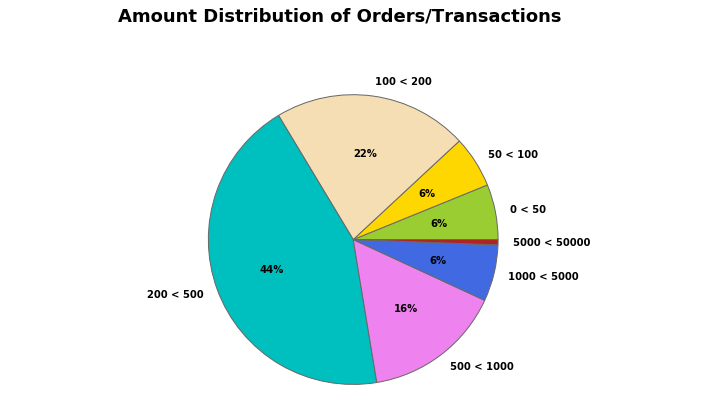

In [60]:
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{} < {}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Amount Distribution of Orders/Transactions", ha='center', fontsize = 18);

<h2>Understanding Product Categories</h2>
<br>
<b>What does the dataset tell us of its products?</b>
<ul>
    <li>Products are identified through the <code>StockCode</code> variable with unique ids.</li>
    <li><code>Description</code> column gives a short description of the products.</li>
</ul>
<br>
What we are going to do is to explore the content of the column <code>Description</code> in order to group the products into different categories.
<br>
<br>
This is going to be very excited and <i>tricky</i>. First we declared a variable that holds a <code>lambda</code> function called <code>is_noun()</code>, what it does is to check if from index 0 and 1 are considered <code>'NN'</code>, we are going to understand what this does and what its purpose is for our object of understanding the <code>Description</code> column.

In [61]:
is_noun = lambda pos: pos[:2] == 'NN'

The method <code>keywords_bags()</code> takes to parameters, <code>dataframe</code> and <code>column</code> with a default value of <code>Description</code>, <i>but what does it do?</i> It does some basic <b>Natural Language Preprocessing</b>.
<br>
<br>
<ol>
    <li>It starts with <code>nltk.download('punkt')</code>, for downloading necessary files for the stemmer.</li>
    <li>The it downloads <code>nltk.download('averaged_perceptron_tagger')</code> necessary for generalation.</li>
    <li>We assign a <i><a href=''>stemmer</a></i> a stemmers does the process of reducing inflection in 
        words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid 
        word in the language, we assign the algorithm for creating a stemmer for the english language.</li>
    <li>We create a dictionary called <code>keywords_roots</code>, here we will store the roots of words</li>
    <li>We create another dictionary called <code>keywords_select</code>, here we will store the association between the 
        root and the keyword.</li>
    <li>We create a dictionary named <code>count_keywords</code>, here we will store how many times a keyword appears.</li>
    <li>We create a list named <code>category_keys</code>, to store the keys of every keyword category.</li>
    <li>We create a variable named <code>icount</code>, this counter will help us on knowing how many times a keyword 
        appears.</li>
    <li>We enter to the first <code>for</code> loop, here we will iterate across the column <code>Description</code>:
        <ol>
            <li>We ask if the value <code><i>s</i></code> in the iteration  is null, with <code>isnull(s)</code>, if it is 
                null we continue with the next iteration, if it is not null we continue with the current iteration.</li>
            <li>We create a variable called <code>lines</code> that holds the result from lowercasing every value of 
                <code>s</code>, lowercasing is done with <code>s.lower()</code></li>
            <li>We create a variable <code>tokenized</code>, it holds a tokenized value from the every word in the string 
                <code>s</code>, tokenized a word  is the process of demarcating and possibly classifying sections of a 
                string of input characters.</li>
            <li>We create a variable that may become a <i>list</i>. Here we will assign the value or values returned from 
                iterating the values that are considered <b>nouns</b> in <code>tokenized</code> var, this is done with 
                asking if every value in <code>tokenized</code> is a noun with the function 
                <code>id_noun(<i>pos</i>)</code></li>
            <li>We enter into an inner <code>for</code> loop, here we will iterate across <code>nouns</code> <i>list</i>
                <ol>
                    <li>We again lowercase the string iteration <code>t</code> with <code>t.lower()</code> and then we 
                        create the var <code>root</code> and assign it the root of <code>t</code> with 
                        <code>stemmer.stem(t)</code>.</li>
                    <li>If <code>root</code> is found in <code>keywords_roots</code> we add <code>t</code> to the 
                        dictionary <code>keyword_roots</code> with the <i>keyword</i> <code>root</code>.</li>
                    <li>We increment by one the value for the <i>keyword</i> <code>root</code> in the dictionary 
                        <code>count_keywords</code>.</li>
                    <li><i>(else)</i>If <code>root</code> is not found in <code>keywords_roots</code>, we assign 
                        <code>t</code> to dictionary <code>keyword_roots</code> with the <i>keyword</i> <code>root</code>.
                    </li>
                    <li>We assign one as value for to the <i>keyword</i> <code>root</code> in the dictionary 
                        <code>count_keywords</code>.</li>
                </ol>
            </li>
        </ol>
    </li>
    <li>We enter into second <code>for</code> loop, we iterate across the <i>keys</i> of<code>keywords_roots</code>:
        <ol>
            <li>If the len of <code>keywords_roots[s]</code> is bigger than <b>1</b> we do the next:
                <ol>
                    <li>We create the var <code>min_length</code> and we asign it the value of <b>1000</b>.</li>
                    <li>We start another <code>for</code> loop, we iterate across the words in 
                        <code>keywords_roots[s]</code> with <code>k</code> as an <i>iterator object</i>, then:
                        <ol>
                            <li>If the len of <code>k</code> is smaller than <code>min_length</code> then we create a var 
                                call <code>category_key</code> we asign the value of <code>k</code> and to 
                                <code>min_length</code> we asign the value of the length of <code>k</code>.</li>
                        </ol>
                    </li>
                    <li>We append <code>category_key</code> to the dictionary <code>category_keys</code>.</li>
                    <li>We assign to <code>keywords_select[s]</code> the value of <code>category_keys</code>.</li>
                </ol>
            </li>
            <li><i>(else)</i> If the len of <code>keywords_roots[s]</code> is not bigger than <b>1</b> we do the next:
                <ol>
                    <li>We append to <code>category_keys</code> dictionary <code>list(keywords_roots[s])[0]</code>, which 
                        is the list of catergories keys.</li>
                    <li>We assign to dictionary keyword  <code>keywords_select[s]</code> 
                        <code>list(keywords_roots[s])[0]</code>, which is the list of catergories keys.</li>
                </ol>
            </li>
        </ol>
    </li>
    <li>We print the number of <i>keywords</i> of the column and the length of the categories found.</li>
    <li>Finally we returned <code>category_keys</code>, <code>keywords_roots</code>, <code>keywords_select</code> and 
        <code>count_keywords</code>.
</ol>

In [62]:
def keywords_bags(dataframe, column = 'Description'):
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the roots of words
    keywords_select = dict()  # associates the root and keyword
    count_keywords  = dict()
    category_keys   = []
    
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywords_roots:                
                keywords_roots[root].add(t)
                count_keywords[root] += 1                
            else:
                keywords_roots[root] = {t}
                count_keywords[root] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    category_key = k ; min_length = len(k)            
            category_keys.append(category_key)
            keywords_select[s] = category_key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("Number of keywords in variable '{}': {}".format(column, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

<code>keywords_bags</code> does the next operations:
<ul>
    <li>Extract <i>nouns</i> or names, that are in the <code>Description</code> column.</li>
    <li>For each <i>nouns</i>:
        <ul>
            <li>Extracts the root of the word.</li>
            <li>Aggregates the set of <i>nouns</i> associated with its particular root.</li>
            <li>Counts the number of times that each root appears in the column <code>Description</code>.</li>
        </ul>
    </li>
    <li>When several words are listed for the same root,  the keyword associated with this root is the 
        shortest name (this systematically selects the singular when there are singular/plural variants).</li>
</ul>

Let's get the list of products:
<br>
We create a new <code>DataFrame</code> object, this new dataframe will have the unique values from the column <code>Description</code>, this values are obtained by <code>df.Description.<i>unique()</i></code>, once we have populated the new dataframe, we change the name of its only column by <code>Description</code>.

In [63]:
df_products = pd.DataFrame(df.Description.unique()).rename(columns = {0: 'Description'})

Now that we have created <code>df_products</code>, we can use the function <code>keywords_bags</code>, we pass the <code>df_products</code> as parameter, this function will return several dictionaries which we are going to hold them in <code>keywords</code>, <code>keywords_roots</code>, <code>keywords_select</code>, <code>count_keywords</code>.

In [64]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_bags(df_products)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kleye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kleye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Number of keywords in variable 'Description': 1484


Great! We now have <b>1484</b> <i>keywords</i>.
Our function returned the next:
<ul>
    <li><code>keywords</code>: The list of extracted <i>keywords</i>.</li>
    <li><code>keywords_roots</code>: A dictionary where its keys are the <i>keywords roots</i> and the values are the lists 
        of words associated with these roots.</li>
    <li><code>keywords_select</code>: A dictionary that has the <i>keywords</i> that where selected for categories.</li>
    <li><code>count_keywords</code>: A dictionary with the numbers of times every word has been used.</li>
</ul>

Now we create a list <code>list_products</code> and we iterate with a <code>for</code> loop the items in <code>count_keyword</code> dictionary with <code>k</code> as iterator index and <code>v</code> as object, we then append to <code>list_products</code> with <code>[keywords_select[k], v</code>, this appends the selected keywords and its values.

In [65]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])

Then we sort this list

In [66]:
product_list = sorted(list_products, key = lambda x:x[1], reverse = True)

<h4>Plotting Most Common Words</h4>

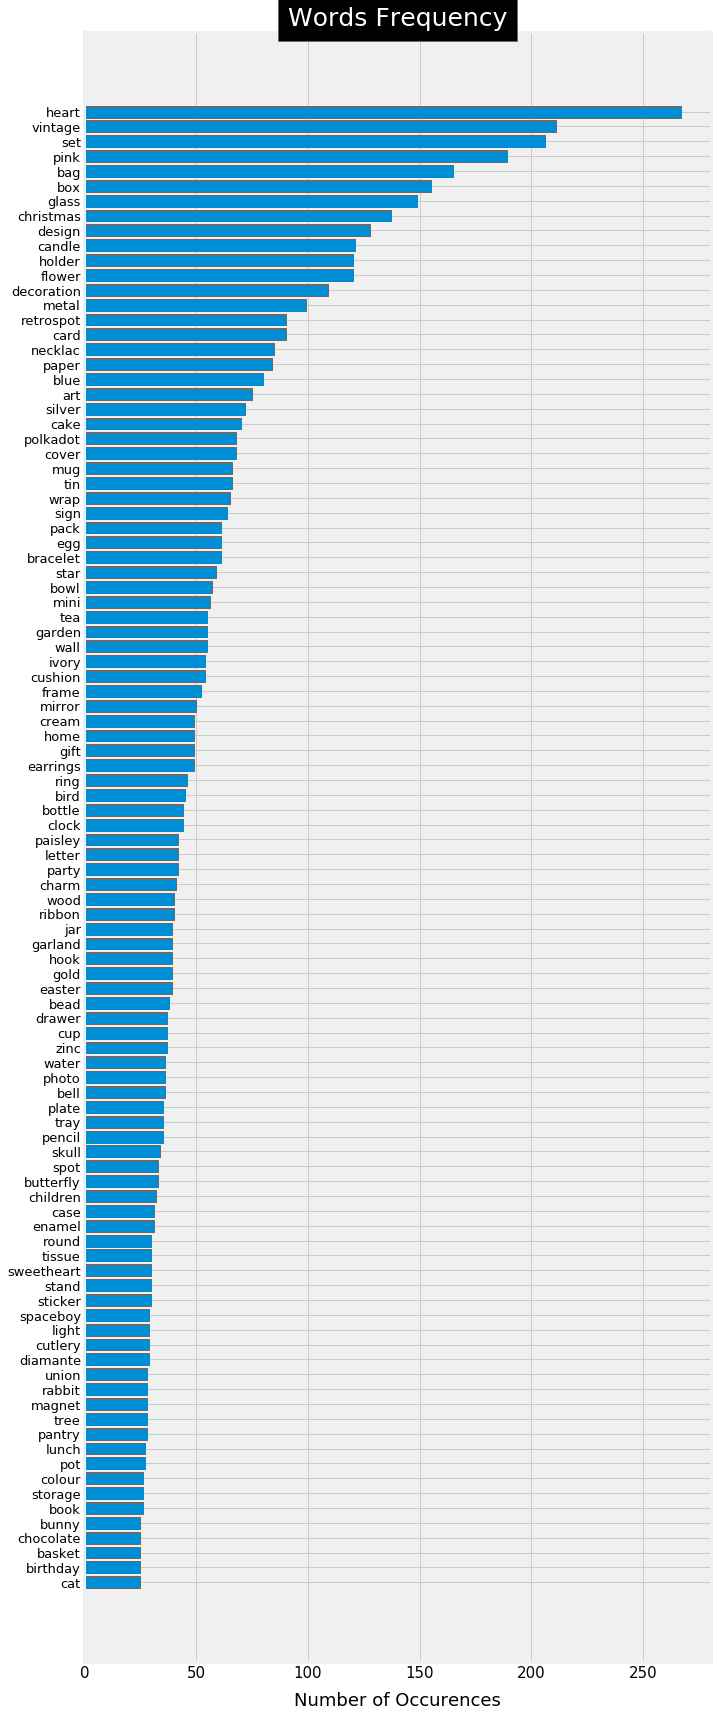

In [67]:
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(10, 30))
y_axis = [i[1] for i in product_list[:100]]
x_axis = [k for k,i in enumerate(product_list[:100])]
x_label = [i[0] for i in product_list[:100]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of Occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.title("Words Frequency",bbox={'facecolor':'k', 'pad':10}, color='w', fontsize = 25)
plt.show()

In [68]:
product_list_DF = pd.DataFrame(product_list, columns=['Word', 'Number_Of_Frequency'])

In [69]:
product_list_DF.Word[:100]

0         heart
1       vintage
2           set
3          pink
4           bag
        ...    
95        bunny
96    chocolate
97       basket
98     birthday
99          cat
Name: Word, Length: 100, dtype: object

In [70]:
fig = go.Figure(
    go.Bar(
        x=product_list_DF.Number_Of_Frequency[:100],
        y=product_list_DF.Word[:100],
        orientation='h',
        text='Word and its Frequency',
        base='relative'))
fig.update_layout(
    yaxis = dict(
        type='category',
        autorange='reversed'
    )
)
fig.show()

Great! We have a dynamic horizontal graph bar that shows the word and its frequency when the horizontal bar is hoovered.
<h4>Defining Product Categories</h4>
<br>
The <code>keywords</code> list contains 1484 <i>keywords</i> and the most frequent ones appear in more than 200 products. When examinating the content of this list, we can notice that some names are useless, do not carry information. Therefore we should discard these words from the analysis that follows and also let's consider only the words that appear more than <b>15</b> times.
<br>
<br>
Let's create the list <code>list_products</code>, then we iterate with a <code>for</code> loop the items in the dictionary <code>count_keywords</code>:
<ol>
    <li>We create the var <code>word</code>, we assign the value of the keyword of <code>keywords_select[k]</code>.</li>
    <li>If the word from <code>word</code> <i>var/list</i> is in this group 
        <code>['pink', 'blue', 'tag', 'green', 'orange']</code> then we do continue with the next iteration.</li>
    <li>If the length of <code>word</code> is smaller than <b>3</b> or samller than <b>15</b> then we
        do continue with the next iteration.</li>
    <li>If the characet <code>+</code> is in <code>word</code> or the characet <code>/</code> is in <code>word</code> 
        then we do continue with the next iteration.</li>
    <li>We append <code>word</code> and the <i>object iterator</i> to <code>list_products</code>.
</ol>

In [71]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 15: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

We then sort the <code>list_products</code> in reverse, with a <code>lambda</code> function. After sorting the list we print how many words were kept.

In [72]:
list_products.sort(key = lambda x:x[1], reverse = True)
print('Number of words that were kept:', len(list_products))

Number of words that were kept: 168


We have the most common <i>keywords</i>, what we are going to do is to create <i>groups or clusters of words</i>, but first we are going to create a $X$ matrix, where $X_i,_j$ will take the value of $1$ if the <i>description</i> of the product $i$ contains the <i>word</i> $j$ and will take the value of $0$ if it does not contains the <i>word</i> $j$.

We create the list <code>list_descriptions</code> with the unique values from <code>Description</code> column, then we create a <code>DataFrame</code> object, that is going to be the matrix <code>X</code>, we are going to iterate with a <code>for</code> loop the list <code>list_descriptions</code> and for iterator <code>k</code> as index we set in <code>X.loc[:, key]</code> a list with the result from <i>mapping</i> the <code>lambda</code> function of <code>x:int(key.upper() in x)</code> in <code>list_descriptions</code>.

In [73]:
list_descriptions = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, frequency in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_descriptions))

Let's take a look at some random samples from the dataframe <code>X</code>

In [74]:
X.sample(5)

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
2663      0        0    0    0    1      0          0       0       0       0   
3596      0        0    0    0    0      0          0       0       0       0   
2532      0        0    0    0    0      0          0       0       0       0   
2679      0        0    0    0    0      1          0       0       0       0   
1366      0        0    0    0    0      0          0       0       0       0   

      ...  jigsaw  rack  coaster  money  cottage  incense  crystal  medium  \
2663  ...       0     0        0      0        0        0        0       0   
3596  ...       0     0        0      0        0        0        0       0   
2532  ...       0     0        0      0        0        0        0       0   
2679  ...       0     0        0      0        0        0        0       0   
1366  ...       0     0        0      0        0        0        0       0   

      dish  image  
2663     0      0  
3596     0      0  
2532     0      0  
2679     0      0  
1366     0      0  

[5 rows x 168 columns]

The $X$ matrix is for indicating the words that are contained in the description of the products using the <b><i>one-hot-encoding</i></b> principle. Now we are going introduce the price range results, therefore, let's add 6 extra columns to this matrix, where we indicate the price range of the products.
<br>
<br>
We create an array that works as range of threshold, <code>threshold</code> and a list <code>label_col</code>.

In [75]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

Let's iterate the range of the lenght of <code>thereshold</code>:
<ol>
    <li>if the <i>iterator index</i> <code>i</code> is equal to <code>len(threshold)-1</code> then:
        <ul>
            <li>We assign to <code>col</code> <code>' > {}'.format(threshold[i])</code>, this is for indicating that is 
                comparing the last value in <code>threshold</code></li>
        </ul>
    </li>
    <li><i>(else)</i> We assign to <code>col</code> <code>'{} &lt; {}'.format(threshold[i],threshold[i+1])</code>,this is 
        for indicating that is the value from <code>threshold[i]</code> is smaller than the value in 
        <code>threshold[i+1]</code>.</li>
    <li>Then we append to <code>label_code</code> the value of <code>col</code>.</li>
    <li>We set in <code>X.loc[:, col]</code> the value of <code>0</code></li>
</ol>
In this <code>for</code> loop we create the new columns that are ranges comparisons.

In [76]:
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = ' > {}'.format(threshold[i])
    else:
        col = '{} < {}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

Let's take a random look at <code>X</code> 

In [77]:
X.sample(10)

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
1188      0        0    0    0    0      0          0       0       0       0   
868       0        0    1    0    0      0          1       0       1       0   
1431      0        0    0    0    0      0          0       0       0       0   
2148      0        0    1    0    0      0          0       0       0       0   
1618      0        0    0    0    0      0          0       0       0       0   
894       0        0    0    0    0      0          0       1       0       0   
2381      0        0    0    0    0      0          0       0       0       0   
1821      0        1    0    1    0      0          0       0       0       0   
1324      0        0    0    0    0      0          0       0       0       0   
3365      0        0    1    0    0      0          0       0       0       0   

      ...  crystal  medium  dish  image  0 < 1  1 < 2  2 < 3  3 < 5  5 < 10  \
1188  ...        0       0     0      0      0      0      0      0       0   
868   ...        0       0     0      0      0      0      0      0       0   
1431  ...        0       0     0      0      0      0      0      0       0   
2148  ...        0       0     0      0      0      0      0      0       0   
1618  ...        0       1     0      0      0      0      0      0       0   
894   ...        0       0     0      0      0      0      0      0       0   
2381  ...        0       0     0      0      0      0      0      0       0   
1821  ...        0       0     0      0      0      0      0      0       0   
1324  ...        0       0     0      0      0      0      0      0       0   
3365  ...        0       0     0      0      0      0      0      0       0   

       > 10  
1188      0  
868       0  
1431      0  
2148      0  
1618      0  
894       0  
2381      0  
1821      0  
1324      0  
3365      0  

[10 rows x 174 columns]

It has 6 new columns ranges!
<br>
Let's go and interate across the list <code>list_descriptions</code>:
<ol>
    <li>We create a var called <code>prix</code> this var will hold the product the <b>mean</b> of <code>UnitPrice</code>
    only if the product is find.</li>
    <li>We assign to var <code>j</code> the value of <b>0</b></li>
    <li>
        We enter into a <code>while</code> loop and its conditios is <code>prix > threshold[j]</code>, this means that if 
        the value of <code>prix</code> is bigger than the value in <code>threshold[j]</code> enters the loops or stays 
        looping.</li>
        <ol>
            <li>We increment the value of <code>j</code> by <b>1</b>.</li>
            <li>If the value of <code>j</code> is equal to the length of <code>threshold</code> we break the loop.</li>
        </ol>
    </li>
    <li>We assign through <code>X.loc[i, label_col[j-1]]</code> the value of <b>1</b>, this means that in the position 
    row equals <code>i</code> and column <code>label_col[j-1]</code>, we put the value of <b>1</b>. We found a word in the descriptions!</li>
</ol>

In [78]:
for i, prod in enumerate(list_descriptions):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

We move to another <code>for</code> loop that iterates through the 
Next we choose the appropiate ranges, we check the number of products in different groups ranges

In [79]:
print("{:<8} {:<20}\n".format('Range', 'Number of Products'))
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = ' > {}'.format(threshold[i])
    else:
        col = '{} < {}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    Number of Products  

0 < 1       964                 
1 < 2       1009                
2 < 3       673                 
3 < 5       606                 
5 < 10      470                 
 > 10       156                 


<h4>Creating Clusters of Products</h4>
<br>
We are going to group the products into different classes, as we have $X$ a binary encoded matrix the most suitable metric for calculating the distances and similarity is the <a href='https://en.wikipedia.org/wiki/Hamming_distance'>Hamming Distance Metric</a>, we are going to use the <code>KModes</code> algorithm, which is the most adequate choice for categorical data and in order to define (approximately) the number of clusters that best represents the data, we use the silhouette score.

In [80]:
from kmodes.kmodes import KModes

for n_clusters in range(3,10):
    kmodes = KModes(init='Huang', max_iter=100, n_clusters=n_clusters, n_init=30, n_jobs=-1, random_state=42)
    clusters = kmodes.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.1097986977210262
For n_clusters = 4 The average silhouette_score is : 0.10913990610086058
For n_clusters = 5 The average silhouette_score is : 0.15400146803139622
For n_clusters = 6 The average silhouette_score is : 0.15201032486828508
For n_clusters = 7 The average silhouette_score is : 0.14005332509406057
For n_clusters = 8 The average silhouette_score is : 0.1460617644016312
For n_clusters = 9 The average silhouette_score is : 0.134876420147708


To understand how <code>KModes</code> works check this <a href='https://www.youtube.com/watch?v=b39_vipRkUo'>video link</a> and this <a herf='https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae'>post</a>.
<br>
<br>To understand why we choose the <code>silhouette_score</code> check this <a href='https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92'>post</a>

Cool! We have clustered the words! Let's choose to separate the dataset into 6 clusters. In order to ensure a good classification at every run of the notebook, we will iterate untill we obtain the best possible <code>silhouette score</code>, which is around 0.16

In [81]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.15:
    kmodes = KModes(init='Huang', max_iter=75, n_clusters=n_clusters, n_init=30, n_jobs=-1, random_state=42)
    clusters = kmodes.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print('For n_clusters = ', n_clusters, ' The average silhouette_score is : ', silhouette_avg)

For n_clusters =  5  The average silhouette_score is :  0.15400146803139622


<h4>Visualizing the Quality and Content of the Clusters</h4>
<br>
Let's first check the number of elements in every class.

In [82]:
pd.Series(clusters).value_counts()

0    1120
2    1009
4     673
3     606
1     470
dtype: int64

Great! We know how many words are in every cluster.

<h4>Visualizing For Selection The Number of Clusters with Silhouette Analysis on KModes Clustering</h4>
<br>
The explanation of <b>Silhouette Analysis</b> and function <code>graph_component_silhouette()</code> are an adaptation from <a href='https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html'>scikit-learn</a> docs.
<br>
<br>
<b>What is Silhouette analysis?</b> 
<blockquote>
    Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot 
    displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a 
    way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]
</blockquote>


<b>What do Silhouette Coefficients mean?</b>
<blockquote>
    Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the 
    neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two 
    neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
</blockquote>

In [83]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

Let's get individual silouhette scores

In [84]:
sample_silhouette_values = silhouette_samples(X, clusters)

Execute the function <code>graph_component_silhouette()</code>.

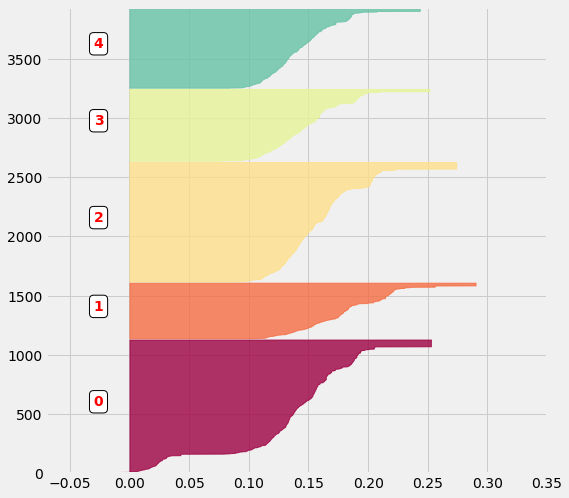

In [85]:
graph_component_silhouette(n_clusters, [-0.07, 0.35], len(X), sample_silhouette_values, clusters)

<h4>Understanding the Silhouette Graph</h4>
<br>
<b>From the official docs</b>
<blockquote>
    In this example the silhouette analysis is used to choose an optimal value for <code>n_clusters</code>. The 
    silhouette plot shows that <code>n_clusters</code> could be a bad pick for the given data due to the presence of 
    clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.
    <br>
    <br>
    Also from the thickness of the silhouette plot the cluster size can be visualized.
</blockquote>

<h4>Visualizing the Content of the Clusters</h4>
<br>
This will be done with <b>Word Clouds!</b>. Let's have a look at the type of objects that each cluster represents by getting a global view of their contents, we must first determine which keywords are the most frequent in each of them.
<br>
<br>
We create a <code>DataFrame</code> object called <code>list_d</code> that holds the descriptions values from the list <code>list_descriptions</code> and we also create anoother list, <code>list_words</code> this list is populated from the words found in <code>list_products</code>.

In [86]:
list_d = pd.DataFrame(list_descriptions)
list_words = [word for (word, frequency) in list_products]

We then create a list called <code>frequency</code> that will hold a <code>dict()</code> structure for every cluster.

In [87]:
frequency = [dict() for _ in range(n_clusters)]

Let's iterate over the range of <code>n_clusters</code>, inside this <code>for</code> loop:
<ol>
    <li>We assign to <code>list_cluster</code> the values from the descriptions in the <code>clusters</code> with the same 
        value of <code>i</code>, <br>
        <code>list_cluster = list_d.loc[clusters == i]</code>.
    </li>
    <li>We enter into an inner <code>for</code> loop, in this new loop we iterare across every word in 
        <code>list_words</code>, with <code>word</code> as interator index:
        <ol>
            <li>If <code>word</code> is in the group <code>['art', 'set', 'heart', 'pink', 'blue', 'tag']</code> then we 
                continue to the next iteration.
            </li>
            <li>We assign to <code>frequency</code> in the <i>key</i> <code>i</code> the value of <code>word</code> the 
                total sum of how many times does <code>word</code> appear in <code>list_cluster.loc[:, 0]</code>.
            </li>
        </ol>
    </li>
</ol>
So what we are going to do is: for every cluster we keep the words that holds in <code>list_cluster</code>, then we iterate for every word in <code>list_words</code>, we skip some interations depending on the word that we already are iterating, then in <code>frequency</code>, which is a list that holds dictionaries, we assing it a word from <code>list_words</code> and the total sum of words appearence.

In [88]:
for i in range(n_clusters):
    list_cluster = list_d.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        frequency[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

The <code>random_color_func()</code> is method that returns a palette of colors.

In [89]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

Here we do the <code>make_wordcloud</code> that will plot the cluster cloud of words

In [90]:
def make_wordcloud(list_wf, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurences = list_wf[0:100]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))

We then start filling with words <code>list_cluster_frequencies</code> with the keys and values from the dictionary in <code>frequency[i]</code>, then we create <code>list_word_frequency</code>, we get into an inner <code>for</code> loop, that iterates through <code>list_cluster_frequencies.items()</code>, once inside this loop we only append to <code>list_word_frequency</code> the index iterator <code>key</code> and <code>value</code> the object at index <i>k</i>, <code>list_word_frequency</code> ends up having the words and its quantity of appeareance from clusters, outside of this loop, we just sort by descending orde the values from <code>list_word_frequency</code> and then we invoke <code>    make_wordcloud()</code> passing <code>list_word_frequency, i+1</code> as parameters.

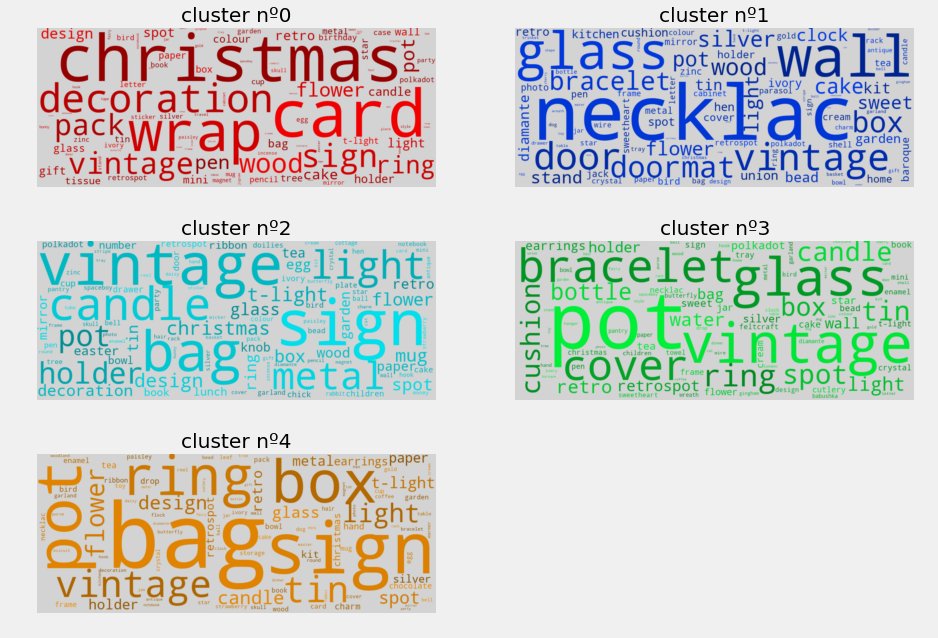

In [91]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_frequencies = frequency[i]

    tone = color[i] # define the color of the words
    list_word_frequency = []
    for key, value in list_cluster_frequencies.items():
        list_word_frequency.append([key, value])
    list_word_frequency.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(list_word_frequency, i+1)   

Bravo! We have grouped our products in different clusters!

<h2>Customer Categories</h2>
<br>
In this section, we are going to create the categories for our customers, but first we need to give some proper format to some data. As we already grouped our products into five different clusters we must incorporate this information into the dataframe, we are going to create a new column/feature called <code>Product_Category</code> and it will hold the cluster of each product.
<br>
<br>
We create <code>product_category</code> dictionary, we iterate trough <i>zipping</i> <code>list_descriptions</code> and <code>clusters</code> as <code>key</code> for descriptions from <code>list_descriptions</code> and <code>val</code> for the number of cluster from <code>clusters</code>, then we assign to <code>product_category[key]</code> the value of <code>val</code>.
<br>
<br>
<code>product_category</code> <i>will have the descriptions and to what cluster they belong</i>.

In [92]:
product_category = dict()
for key, val in zip (list_descriptions, clusters):
    product_category[key] = val 

We create the column <code>Product_Category</code> and we assign it the <i>categories</i> by <i>mapping</i> 
with <br><code>df_cleaned.loc[:, 'Description'].map(product_category)</code>.

In [93]:
df_cleaned['Product_Category'] = df_cleaned.loc[:, 'Description'].map(product_category)

Let's take a random look at the dataframe

In [94]:
df_cleaned.sample(5)

InvoiceNo StockCode                        Description  Quantity  \
416286    572552     22602  RETROSPOT WOODEN HEART DECORATION         2   
302651    563440    35818B         ACRYLIC JEWEL ICICLE, BLUE        24   
118644    546465     22247      BUNNY DECORATION MAGIC GARDEN         6   
252799    559138     22098          BOUDOIR SQUARE TISSUE BOX         4   
186748    552880     21090         SET/6 COLLAGE PAPER PLATES        12   

             InvoiceDate  UnitPrice CustomerID         Country  \
416286  10/24/2011 17:07       1.63      14096  United Kingdom   
302651   8/16/2011 13:12       0.38      13189  United Kingdom   
118644   3/14/2011 10:57       0.85      14395  United Kingdom   
252799    7/6/2011 13:35       0.39      16919  United Kingdom   
186748    5/12/2011 9:59       0.39      18245  United Kingdom   

        QuantityCanceled  TotalPrice  Product_Category  
416286                 0        3.26                 0  
302651                 0        9.12                 0  
118644                 0        5.10                 0  
252799                 0        1.56                 0  
186748                 0        4.68                 0

Cool! We now have every transaction and its category.
<h4>Grouping the Products</h4>
<br>
Good! Let's create a <i>Category_N</i> variables (with  $N$ $∈$ $[0:4]$ ) that contains the amount spent in each product category.

In [95]:
for i in range(5):
    col = 'Category_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['Product_Category'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

Let's see some samples:

In [96]:
df_cleaned.sample(5)

InvoiceNo StockCode                     Description  Quantity  \
191476    553369     23170        REGENCY TEA PLATE ROSES         12   
453686    575491     23306  SET OF 36 PANTRY PAPER DOILIES         3   
310031    564161    72799F  IVORY PILLAR CANDLE GOLD FLOCK        12   
91603     544109     22087        PAPER BUNTING WHITE LACE        14   
267861    560364     22467               GUMBALL COAT RACK        36   

            InvoiceDate  UnitPrice CustomerID         Country  \
191476  5/16/2011 14:30       1.65      15044  United Kingdom   
453686  11/9/2011 17:47       1.45      15531  United Kingdom   
310031  8/23/2011 13:13       2.95      14523  United Kingdom   
91603   2/16/2011 10:56       2.95      12841  United Kingdom   
267861  7/18/2011 12:15       2.10      16705  United Kingdom   

        QuantityCanceled  TotalPrice  Product_Category  Category_0  \
191476                 0       19.80                 2         0.0   
453686                 0        4.35                 2         0.0   
310031                 0       35.40                 4         0.0   
91603                  0       41.30                 4         0.0   
267861                 0       75.60                 4         0.0   

        Category_1  Category_2  Category_3  Category_4  
191476         0.0       19.80         0.0         0.0  
453686         0.0        4.35         0.0         0.0  
310031         0.0        0.00         0.0        35.4  
91603          0.0        0.00         0.0        41.3  
267861         0.0        0.00         0.0        75.6

Now we create a temporal <code>DataFrame</code> object <code>temp</code>, in this new temporal dataframe we are going to hold the <code>TotalPrice</code> sum grouped by <code>CustomerID</code> and <code>InvoiceNo</code>, then we are going to assign to <code>cart_price</code> the values from <code>temp</code>.

In [97]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
cart_price = temp.rename(columns = {'TotalPrice':'Cart Price'})

Then we iterate in a <code>for</code> loop a range of <b>5</b> iterations with <code>i</code> as iterator index, inside this loop we first assign to the var <code>col</code> the name of the column <code>Category_<i>{i}</i></code>, then we assign to <code>temp</code> the result from grouping <code>CustomerID</code> and <code>InvoiceNo</code> and the sum of <code>col</code>, then we assign to <code>cart_price</code> in the column <code>col</code> the values in <code>temp</code>. 

In [98]:
for i in range(5):
    col = 'Category_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    cart_price.loc[:, col] = temp 


Now what are we going to do is to add the dates of the transactions to the dataframe <code>cart_price</code>

In [99]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype(np.datetime64).astype(np.int64)
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
cart_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

Great! Now we are going to filter in <code>cart_price</code> the values from the column <code>Cart Price</code> that are bigger than <b>0</b>, then we sort its values in ascending order according to <code>CustomerID</code> column and display the first 5 samples in this dataframe.

In [100]:
cart_price = cart_price[cart_price['Cart Price'] > 0]
cart_price.sort_values('CustomerID', ascending = True).head(5)

CustomerID InvoiceNo  Cart Price  Category_0  Category_1  Category_2  \
1      12347    537626      711.79       23.40      124.44       187.2   
2      12347    542237      475.39      122.59        0.00       130.5   
3      12347    549222      636.25      119.25        0.00       330.9   
4      12347    556201      382.52       41.40       19.90        74.4   
5      12347    562032      584.91       99.55       97.80       109.7   

   Category_3  Category_4                   InvoiceDate  
1      293.35       83.40 2010-12-07 14:57:00.000001024  
2      169.20       53.10 2011-01-26 14:29:59.999999744  
3      115.00       71.10 2011-04-07 10:42:59.999999232  
4      168.76       78.06 2011-06-09 13:01:00.000000256  
5      158.16      119.70 2011-08-02 08:48:00.000000000

Let's print the oldest transaction and the newest one

In [101]:
print(cart_price['InvoiceDate'].min(), ' to ',  cart_price['InvoiceDate'].max())

2010-12-01 08:26:00  to  2011-12-09 12:50:00


The <code>cart_price</code> dataframe holds information of transactions during 12 months. 

<h4>Taking Care of Data Over Time</h4>
<br>
The main objectives of this notebook is to  develop a model capable of characterizing and anticipating the habits of the customers visiting the site <i>from their first visit</i>. <b><i>How can we test the model in a realistic way?</i></b>, We can split the dataset by keeping the first 10 months for training and development of the model and the last two months for testing how good our model is.
<br>

<i>Nice approach?</i> Now let's define a var <code>date_limit</code> which is going to work as the limit day for comparison.

In [102]:
date_limit = np.datetime64(datetime.date(2011, 10, 1))
date_limit

numpy.datetime64('2011-10-01')

<code>train_set</code> will hold all the data from <code>cart_price</code> that was registered before the date <code>2011-10-1</code> and <code>test_set</code> will hold all the data from <code>cart_price</code> that was registered during and after the date <code>2011-10-1</code>. Then we copy all the data from <code>train_set</code> to <code>cart_price</code>.

In [103]:
train_set = cart_price[cart_price['InvoiceDate'] < date_limit]
test_set = cart_price[cart_price['InvoiceDate'] >= date_limit]

cart_price = train_set.copy(deep = True)

Let's see the info <code>train_set</code> holds

In [104]:
train_set.tail(5)

CustomerID InvoiceNo  Cart Price  Category_0  Category_1  Category_2  \
18614      18283    557956      192.80       43.34         0.0       62.80   
18615      18283    560025      137.39       27.53         0.0       51.45   
18616      18283    560032        2.50        0.00         0.0        2.50   
18617      18283    565579      134.90       36.20         0.0       51.20   
18624      18287    554065      765.28       40.68        34.0      540.90   

       Category_3  Category_4                   InvoiceDate  
18614        17.4       69.26 2011-06-23 19:20:00.000000000  
18615        16.6       41.81 2011-07-14 13:00:00.000000000  
18616         0.0        0.00 2011-07-14 13:20:00.000000000  
18617         0.0       47.50 2011-09-05 12:34:59.999998720  
18624        15.0      134.70 2011-05-22 10:38:59.999998976

Let's see the info <code>test_set</code> holds

In [105]:
test_set.head(5)

CustomerID InvoiceNo  Cart Price  Category_0  Category_1  Category_2  \
6       12347    573511     1294.32      230.80       55.60      203.30   
7       12347    581180      224.82       38.58       30.00      100.80   
12      12349    577609     1757.55      529.82      358.35      465.86   
21      12352    574275      311.73      100.80       53.90      107.30   
27      12356    576895       58.35       58.35        0.00        0.00   

    Category_3  Category_4                   InvoiceDate  
6       368.72      435.90 2011-10-31 12:25:00.000001280  
7         0.00       55.44 2011-12-07 15:52:00.000000000  
12      188.30      215.22 2011-11-21 09:51:00.000000256  
21       22.50       27.23 2011-11-03 14:36:59.999999744  
27        0.00        0.00 2011-11-17 08:40:00.000000000

Then we create the <code>DataFrame</code> object <code>transactions_per_user</code>, in this new dataframe we assign the values of <code>count</code>, <code>min</code>, <code>max</code>, <code>mean</code> and <code>sum</code> from gruping by <code>CustomerID</code> and <code>Cart Price</code>. The information on <code>transactions_per_user</code> is just basic statistics of the values found in the <code>Cart Price</code> of each customer.

In [106]:
transactions_per_user=cart_price.groupby(by=['CustomerID'])['Cart Price'].agg(['count','min','max','mean','sum'])

Look at it:

In [107]:
transactions_per_user.head(5)

count     min     max        mean      sum
CustomerID                                            
12347           5  382.52  711.79  558.172000  2790.86
12348           4  227.44  892.80  449.310000  1797.24
12350           1  334.40  334.40  334.400000   334.40
12352           6  144.35  840.30  345.663333  2073.98
12353           1   89.00   89.00   89.000000    89.00

Now we do iterate in a <code>for</code> loop a range of <b>5</b> iterations, as we have done before we create a var <code>col</code> that is going to hold the name of <code>Category_<i>{i}</i></code>, then here comes the magic! We assign to <code>transactions_per_user</code> in the column of the value that <code>col</code> has the percentage of transactions per category.

In [108]:
for i in range(5):
    col = 'Category_{}'.format(i)
    transactions_per_user.loc[:,col] = cart_price.groupby(by=['CustomerID'])[col].sum() / transactions_per_user['sum']*100

Let's look at it:

In [109]:
transactions_per_user.head(5)

count     min     max        mean      sum  Category_0  \
CustomerID                                                           
12347           5  382.52  711.79  558.172000  2790.86   14.554295   
12348           4  227.44  892.80  449.310000  1797.24   58.046783   
12350           1  334.40  334.40  334.400000   334.40   23.654306   
12352           6  144.35  840.30  345.663333  2073.98   53.725205   
12353           1   89.00   89.00   89.000000    89.00   44.719101   

            Category_1  Category_2  Category_3  Category_4  
CustomerID                                                  
12347         8.676179   29.836681   32.408290   14.524555  
12348         0.000000   41.953217    0.000000    0.000000  
12350         0.000000   48.444976    0.000000   27.900718  
12352        14.301006   12.892120   15.711338    3.370331  
12353        22.359551   13.033708    0.000000   19.887640

We reset the index of <code>transactions_per_user</code>, we group <code>cart_price</code> dataframe by <code>CustomerID</code> and sum the values from <code>Category_0</code> column, therefore <code>cart_price</code> will have how much each customer has bought in <code>Category_0</code>, last we sort <code>transactions_per_user</code> by ascending order according to <code>CustomerID</code> values, we display the first 5 samples of <code>transactions_per_user</code> sorted.

In [110]:
transactions_per_user.reset_index(drop=False, inplace=True)
cart_price.groupby(by=['CustomerID'])['Category_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending=True).head(5)

CustomerID  count     min     max        mean      sum  Category_0  \
0      12347      5  382.52  711.79  558.172000  2790.86   14.554295   
1      12348      4  227.44  892.80  449.310000  1797.24   58.046783   
2      12350      1  334.40  334.40  334.400000   334.40   23.654306   
3      12352      6  144.35  840.30  345.663333  2073.98   53.725205   
4      12353      1   89.00   89.00   89.000000    89.00   44.719101   

   Category_1  Category_2  Category_3  Category_4  
0    8.676179   29.836681   32.408290   14.524555  
1    0.000000   41.953217    0.000000    0.000000  
2    0.000000   48.444976    0.000000   27.900718  
3   14.301006   12.892120   15.711338    3.370331  
4   22.359551   13.033708    0.000000   19.887640

We are almost done! Let's define two additional columns for the number of days elapsed since the first purchase ( <code>FirstPurchase</code> ) and the number of days since the last purchase ( <code>LastPurchase</code> ):

We take in <code>last_date</code> the maximun date on <code>InvoiceDate</code> from <code>cart_price</code>.

In [111]:
last_date = cart_price['InvoiceDate'].max().date()

Let's create the next dataframes <code>first_registration</code> for the first date that a customer made a transaction, this is done through grouping by <code>CustomerID</code> and taking the minimun date from <code>InvoiceDate</code> and for 
<code>last_purchase</code> dataframe we take the last date that a customer made a transaction, this is done through grouping by <code>CustomerID</code> and taking the maximum date from <code>InvoiceDate</code>.

In [112]:
first_registration = pd.DataFrame(cart_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(cart_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

Looking at <code>first_registration</code>:]

In [113]:
first_registration.head(5)

InvoiceDate
CustomerID                              
12347      2010-12-07 14:57:00.000001024
12348      2010-12-16 19:09:00.000000000
12350      2011-02-02 16:01:00.000000000
12352      2011-02-16 12:32:59.999999744
12353      2011-05-19 17:47:00.000000000

Looking at <code>last_purchase</code>:

In [114]:
last_purchase.head(5)

InvoiceDate
CustomerID                    
12347      2011-08-02 08:48:00
12348      2011-09-25 13:13:00
12350      2011-02-02 16:01:00
12352      2011-09-28 14:58:00
12353      2011-05-19 17:47:00

We have seen what info do <code>first_registration</code> and <code>last_purchase</code> are holding, now we are going to calculate how many days have passed, this is done by creating two separete dataframe, one for <code>first_registration</code> and <code>last_purchase</code>.
<br>
<br>
Let's create <code>test_fp</code> a dataframe, where we are going to apply a <code>lambda</code> function that calculates the days that have  to <code>first_registration</code> with the function <code>applymap(lambda x:(last_date - x.date()).days)</code>.
<br>
<br>
Now we are going to create <code>test_lp</code> a dataframe, where we are going to apply a <code>lambda</code> function that calculates the days that have  to <code>last_purchase</code> with the function <code>applymap(lambda x:(last_date - x.date()).days)</code>.

In [115]:
test_fp  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test_lp = last_purchase.applymap(lambda x:(last_date - x.date()).days)

<code>test_fp</code> it has the dates that have passed from the first purchase from every customer.

In [116]:
test_fp.sample(5)

InvoiceDate
CustomerID             
15146               221
18262                70
14740               213
18108               184
13092               289

<code>test_lp</code> it has the dates that have passed from the last purchase from every customer.

In [117]:
test_lp.sample(5)

InvoiceDate
CustomerID             
16092                44
15238                25
15763                 7
13023                59
14535                57

We are going to create new columns for <code>transactions_per_user</code>, one column called <code>FirstPurchase</code> and other column named <code>LastPurchase</code>.
<br>
<br>
<code>FirstPurchase</code>: is going to take the values from <code>test_fp</code>, <i>we do not reset its index</i>, this will match the <code>CustomerID</code> in <code>transactions_per_user</code>.
<br>
<code>LastPurchase</code>: is going to take the values from <code>test_lp</code>, <i>we do not reset its index</i>, this will match the <code>CustomerID</code> in <code>transactions_per_user</code>.

In [118]:
transactions_per_user.loc[:, 'FirstPurchase'] = test_fp.reset_index(drop=False)['InvoiceDate']
transactions_per_user.loc[:, 'LastPurchase'] = test_lp.reset_index(drop=False)['InvoiceDate']

Showing some samples

In [119]:
transactions_per_user.sample(5)

CustomerID  count     min     max        mean      sum  Category_0  \
1479      14713      9  124.95  372.24  225.278889  2027.51   20.167102   
2187      15889      2  148.00  272.07  210.035000   420.07   24.236437   
107       12513      1  586.79  586.79  586.790000   586.79   41.375961   
1106      14113      2  408.00  492.88  450.440000   900.88    2.237812   
2744      16810      1  309.54  309.54  309.540000   309.54    6.041222   

      Category_1  Category_2  Category_3  Category_4  FirstPurchase  \
1479   15.728652   23.091378   16.784134   24.228734            295   
2187   18.485014   22.498631   13.759611   21.020306            299   
107     0.000000   42.485387    3.834421   12.304231             42   
1106    0.000000    1.665039   76.383092   19.714057            284   
2744    6.428894   12.515345   50.785036   24.229502            122   

      LastPurchase  
1479            29  
2187            86  
107             42  
1106             8  
2744           122

<b>How many customer do only buy once? How much do they represent in the dataset?</b>

In [120]:
one_time_customers = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
total_customers = transactions_per_user.shape[0]
print('Quantity of One Time Buyers: {}' .format(one_time_customers))
print('Quantity of Customers: {}' .format(total_customers))
print('Percentage of One Time Buyers: {:.2f}%' .format((one_time_customers/total_customers) * 100))

Quantity of One Time Buyers: 1448
Quantity of Customers: 3612
Percentage of One Time Buyers: 40.09%


<h3>Creating Customers Categories</h3>
<br>
<h4>Data Encoding</h4>
<br>
<code>transactions_per_user</code> is a dataframe that contains a summary of all the transaction that were made by each client. This information will be used to characterize the different types of customers and only keep a subset of variables:
<br>
<br>
Let's create a list call <code>list_cols</code> that will hold the features that are going to be used for the model to learn patterns in order to define the clusters.

In [121]:
list_cols = ['count','min','max','mean','Category_0','Category_1','Category_2','Category_3','Category_4', 'LastPurchase', 'FirstPurchase']

A copy of <code>transactions_per_user</code> will be contained in <code>selected_customers</code>, then we create a <code>numpy</code> matrix named <code>matrix</code>, this matrix will be fullfied with the selected columns from <code>selected_customers[list_cols]</code>.

In [122]:
selected_customers = transactions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].to_numpy()

We are going to use <code>MinMaxScaler()</code> as a scaler for our data, <b>Why?</b> Well, we don't want to loose the importance of clients that are outliers. Remember more than <b>40%</b> bought just once, it means that at least <b>60%</b> buys more frequently. 

In [123]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(matrix)
minmaxscaled_matrix = minmax_scaler.transform(matrix)

<h3>Creation of Customer Categories</h3>
<br>
Well it is the time we all have been waiting, the creation of this clusters will be done by using <code>KMeans</code>, it is a very similar process as the one we did with creating the clusters for words with <code>KModes</code>.
<br>
<br>
This may take a while!
<br>
<br>
The best number of clusters will be defined by the technique <a href='https://github.com/kleyersoma/Clustering_Analysis/blob/master/clustering_analysis.ipynb'>Elbow Method</a>.

In [124]:
clusters_history = pd.DataFrame()
clusters_history['cluster_range'] = range(1, 15)
inertia = []

In [125]:
for n_clusters in range(1, 15):
    kmeans = KMeans(init='k-means++', max_iter=100, n_clusters=n_clusters, n_init=100, n_jobs=-1, random_state=42).fit(minmaxscaled_matrix)
    inertia.append(kmeans.inertia_)

In [126]:
clusters_history['inertia'] = inertia
clusters_history

cluster_range      inertia
0               1  1172.491621
1               2   892.979063
2               3   699.666892
3               4   642.114021
4               5   594.817918
5               6   552.753923
6               7   514.560140
7               8   485.678005
8               9   461.662412
9              10   441.820711
10             11   425.717071
11             12   410.705303
12             13   398.448404
13             14   386.120497

In [127]:
import altair as alt
alt.Chart(clusters_history).mark_line().encode(x='cluster_range', y='inertia', tooltip=['cluster_range', 
                             'inertia']).interactive()

alt.Chart(...)

Great! It looks like <b>14</b> clusters is the right value for <code>n_clusters</code>

In [128]:
n_clusters = 14
kmeans = KMeans(init='k-means++', max_iter=100, n_clusters=n_clusters, n_init=100, n_jobs=-1, random_state=42)
kmeans.fit(minmaxscaled_matrix)
clients_clusters = kmeans.predict(minmaxscaled_matrix)
silhouette_avg = silhouette_score(minmaxscaled_matrix, clients_clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 14 The average silhouette_score is : 0.17389052391313733


Let's see how many clients each cluster has

In [129]:
pd.DataFrame(pd.Series(clients_clusters).value_counts(), columns = ['Quantity of Clients in Cluster']).T

1    4    8    3    5    7    11   2    0   \
Quantity of Clients in Cluster  754  513  405  345  336  263  161  141  138   

                                 6    12   9    10  13  
Quantity of Clients in Cluster  133  123  118  110  72

As we did for word clustering by visualizing with Silhouette Analysis, we are going to do it with <code>clients_clusters</code>

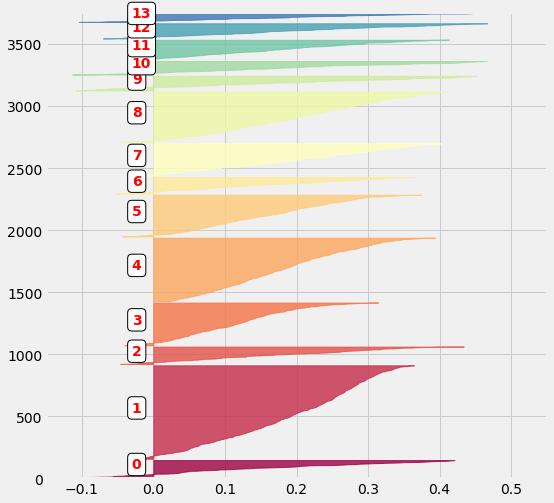

In [130]:
sample_silhouette_values = silhouette_samples(minmaxscaled_matrix, clients_clusters)
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(minmaxscaled_matrix), sample_silhouette_values, clients_clusters)

Some of the clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, we start by adding to the <code>selected_customers</code> dataframe a variable that defines the cluster to which each client belongs:

In [131]:
selected_customers.loc[:, 'cluster'] = clients_clusters

Then, We average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average cart price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable size ):

In [132]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test_fp = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test_fp = test_fp.T.set_index('cluster', drop = True)
    test_fp['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test_fp])

In [133]:
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())
merged_df = merged_df.sort_values('sum')

number of customers: 3612


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [134]:
list_index = []
for i in range(5):
    column = 'Category_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])

In [135]:
list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]

In [136]:
merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'Category_0', 'Category_1', 'Category_2', 'Category_3', 'Category_4', 'size']])

cluster     count         min         max        mean          sum  \
0       2.0  1.560284  279.313475  368.589858  323.224667   509.189716   
1       9.0  2.559322  204.047797  459.268051  293.762022  2079.974746   
2      11.0  1.378882  238.034224  280.810062  259.029157   340.703043   
3       6.0  1.556391  291.066767  387.921053  334.718149   543.676541   
4      10.0  2.718182  247.083909  533.569091  359.775213  1380.342636   
5       7.0  1.452471  290.655665  343.086160  315.543635   438.901255   
6       5.0  1.651786  304.564524  424.043128  361.629309   575.528396   
7       0.0  2.326087  244.842391  366.403775  303.057810   648.278051   
8      12.0  1.975610  237.888211  361.736260  290.983129   666.076504   
9       8.0  1.525926  457.086472  559.342175  503.853821   715.926422   
10      3.0  1.982609  293.463681  491.028841  386.545389   738.891797   
11     13.0  2.000000  215.330000  407.811250  302.151609   843.294306   
12      4.0  4.173489  223.918791  616.755926  397.274679  1665.469766   
13      1.0  8.969496  154.803688  908.234350  417.688027  4529.063131   

    Category_0  Category_1  Category_2  Category_3  Category_4  size  
0    59.622395    5.846923   18.413704    6.550897    9.566082   141  
1     6.758711   73.998849    5.561695    7.075535    6.605210   118  
2    14.667054    6.131089   57.635155    7.957489   13.609213   161  
3     9.537884   13.084939   13.947537   49.437202   14.019804   133  
4     4.727964    3.246782    7.776629    3.860067   80.388558   110  
5    20.784270   18.970685   20.437256   16.897432   22.933169   263  
6    21.286530   20.523165   21.165185   17.760730   19.264390   336  
7    12.897397    5.115080   68.484369    5.068525    8.445415   138  
8    75.747996    6.118141    8.158665    4.446996    5.528202   123  
9    19.998275   14.356812   26.991327   16.213344   22.440408   405  
10   19.206257   17.162567   22.853200   14.931036   25.863771   345  
11    6.418654    8.369559    9.142740   67.178281    8.926974    72  
12   20.644904   12.475124   29.744166   15.102758   22.034765   513  
13   19.999288   15.877470   24.022063   17.495803   22.647582   754

<h4>Customers Morphology</h4>

In [137]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

In [138]:
class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

This allows to have a global view of the content of each cluster:

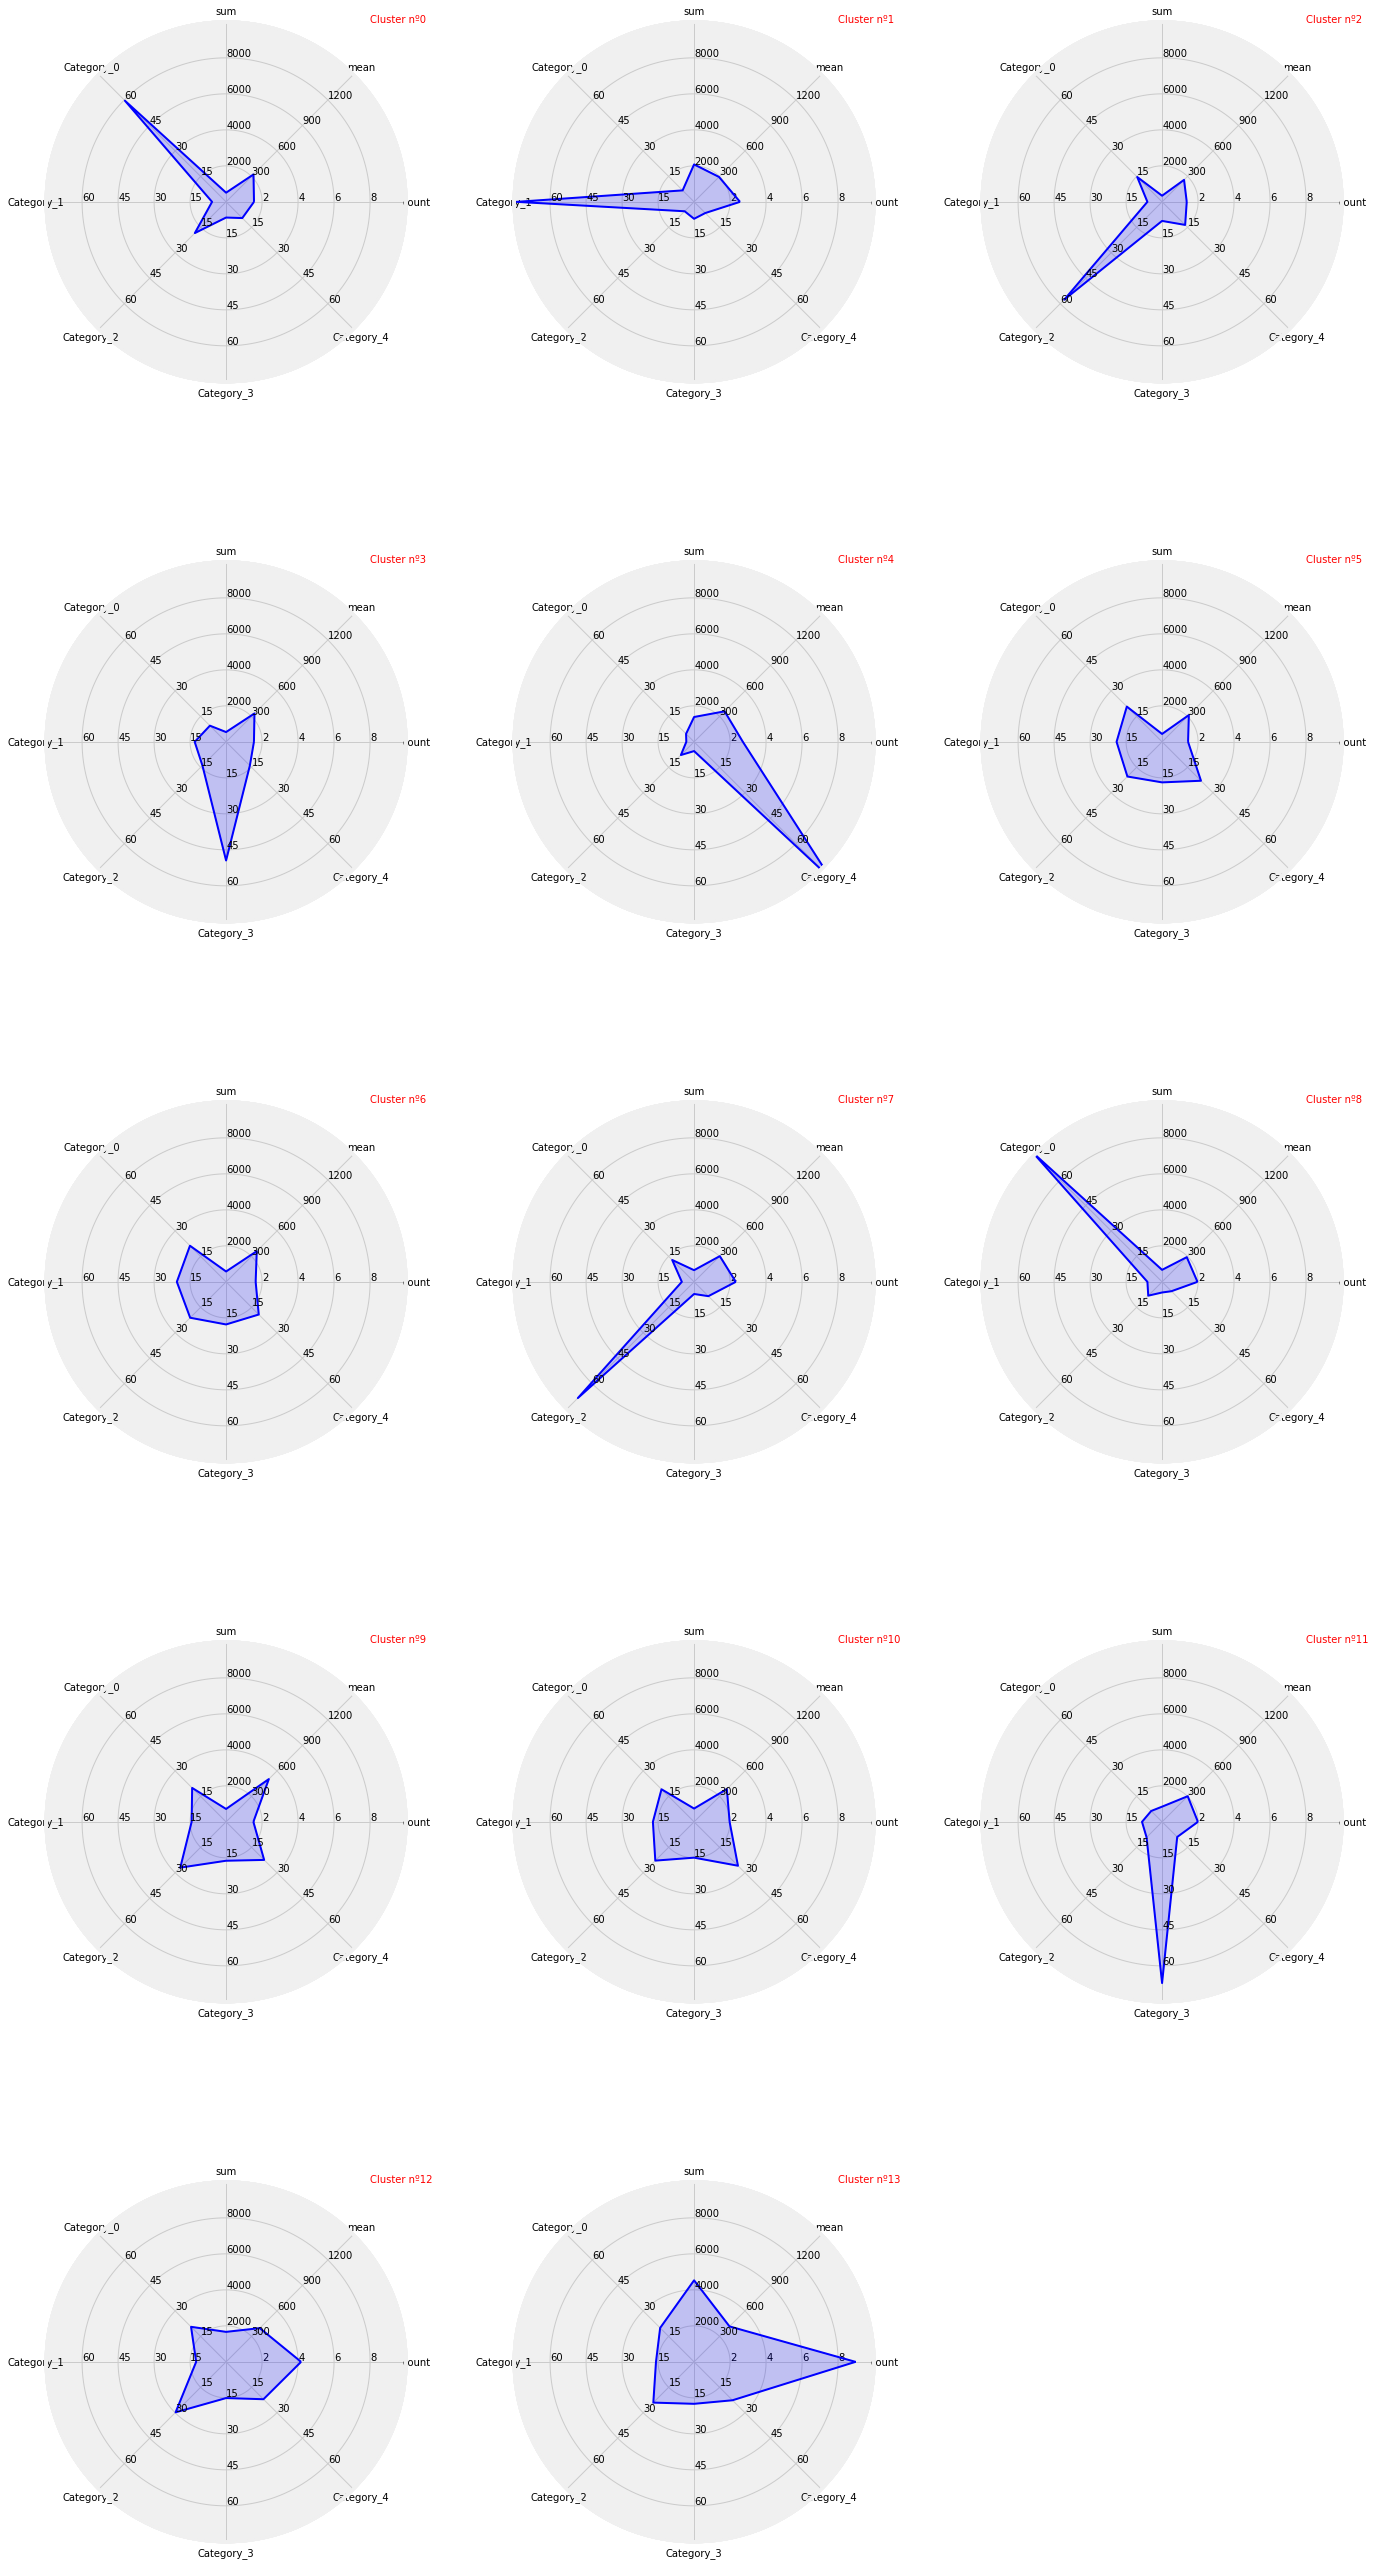

In [201]:
fig = plt.figure(figsize=(15,25))

attributes = ['count', 'mean', 'sum', 'Category_0', 'Category_1', 'Category_2', 'Category_3', 'Category_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.1) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'Cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

<h2>Classifying Customers</h2>

In [140]:
def clusters_histogram(y_cluster, title ):
    x_unique, y_counts = np.unique(y_cluster, return_counts=True)

    x = x_unique
    y = y_counts
    # Use the hovertext kw argument for hover text
    fig = go.Figure(data=[go.Bar(x=x,
                                 y=y,
                                 text='Clusters and Quantity of Clients')])
    # Customize aspect
    fig.update_traces(marker_color='rgb(158,202,225)',
                      marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5, opacity=0.6)

    fig.update_layout(
        title_text='Histogram of Clusters Distribution and Quantity Of Clients in set {}'.format(title),
        title_x=0.5,
        xaxis = dict(
                type='category',
                title='Clusters'),
        yaxis = dict(title='Quantity of Clients')
    )
    fig.show()

In [141]:
def clusters_predictions_histogram(y_cluster, y_predictions, title):
    # Calculate y_cluster unique values and their frequency
    x_unique, y_counts = np.unique(y_cluster, return_counts=True)

    x = x_unique
    y = y_counts
    # Use the hovertext kw argument for hover text
    fig = go.Figure()
    
    fig.add_trace(go.Bar(x=x,
                         y=y,
                         name='Y true Clusters',
                         text='Cluster and Quantity of Clients',
                         marker_color='rgb(158,202,225)',
                         marker_line_color='rgb(8,48,107)',
                         marker_line_width=1.5,
                         opacity=0.6))
    
    # Calculate y_predictions unique values and their frequency
    x_unique, y_counts = np.unique(y_predictions, return_counts=True)

    x = x_unique
    y = y_counts
    
    fig.add_trace(go.Bar(x=x,
                         y=y,
                         name='Y Predictions Clusters',
                         marker_color='lightsalmon',
                         marker_line_color='rgb(18,38,207)',
                         marker_line_width=1.5,
                         opacity=0.6))

    fig.update_layout(barmode='group',
                      bargroupgap=0.2,
                      title_text='Histogram of Clusters Distribution and Quantity Of Clients in {}'.format(title),
                      title_x=0.5,
                      xaxis = dict(
                          type='category',
                          title='Clusters'),
                      yaxis = dict(title='Quantity of Clients')
    )
    fig.show()

In [395]:
def crossval_learningcurve(k=None, scores=None, k_fp=None, scores_fp=None, k_lp=None, scores_lp=None):
    #import plotly.express as px
    #df = px.data.gapminder().query("continent=='Oceania'")
    #fig = px.line(df, x="year", y="lifeExp", color='country')

    fig = go.Figure()
    
    if k:
        fig.add_trace(go.Scatter(x=np.arange(1,k+1),
                                     y=scores,
                                     name='Full Year',
                                     text='Cross Validation Fold and Accuracy Score'))
    if k_fp:
        fig.add_trace(go.Scatter(x=np.arange(1,k_fp+1),
                                 y=scores_fp,
                                 name='First Ten months',
                                 text='Cross Validation Fold and Accuracy Score'))
    if k_lp:
        fig.add_trace(go.Scatter(x=np.arange(1,k_lp+1),
                                 y=scores_lp,
                                 name='Last Two months',
                                 text='Cross Validation Fold and Accuracy Score'))
    
    fig.update_layout(
        title_text='Learning Curve for Cross Validation Folds with {} Folds'.format(k),
        title_x=0.5,
        xaxis = dict(
                type='category',
                title='k'),
        yaxis = dict(title='Accuracy Score')
    )
    
    fig.show()

In [264]:
def comparing_training_loss_and_val_acc(epochs, loss_curve, validation_scores):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs,
                             y=loss_curve,
                             name='Training Loss',
                             text='Epoch and Training Loss'))
    
    fig.add_trace(go.Scatter(x=epochs,
                             y=validation_scores,
                             name='Validation Accuracy',
                             text='Epoch and Validation Accuracy Score'))
    fig.update_layout(
        title_text='Validation Accuracy and Training Loss',
        title_x=0.3,
        xaxis = dict(
            title='Epochs'),
        yaxis = dict(title='Loss and Accuracy Score')
    )
    fig.show()

In [143]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [273]:
def MLP_Classifier():
    mlp_clf = MLPClassifier(hidden_layer_sizes=(30, 30, 30),
                            activation='relu',
                            solver='adam',
                            alpha=0.0001,
                            batch_size=32,
                            learning_rate='adaptive',
                            learning_rate_init=0.001,
                            power_t=0.5,
                            max_iter=246,
                            shuffle=True,
                            random_state=42,
                            tol=0.0001,
                            verbose=False,
                            warm_start=True,
                            momentum=0.9,
                            nesterovs_momentum=True,
                            early_stopping=True,
                            validation_fraction=0.05,
                            beta_1=0.9,
                            beta_2=0.999,
                            epsilon=1e-08,
                            n_iter_no_change=100)
    return mlp_clf

In [144]:
columns = ['count','min','max','mean', 'Category_0', 'Category_1', 'Category_2', 'Category_3', 'Category_4', 'LastPurchase', 'FirstPurchase']
X_fp = selected_customers[columns]
Y_fp = selected_customers['cluster']

In [292]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_fp, Y_fp, train_size = 0.8, random_state=42)

In [293]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [295]:
from sklearn.model_selection import cross_validate 
cv_results_fp = cross_validate(MLP_Classifier(),
                            X_train,
                            y_train,
                            cv=10, 
                            return_train_score=True, 
                            scoring='accuracy') 

In [296]:
for k_fp, s_fp in enumerate(cv_results_fp['test_score']):
    print("Fold {} with Test Accuracy Score: {}".format(k_fp, s_fp))

Fold 0 with Test Accuracy Score: 0.9491525423728814
Fold 1 with Test Accuracy Score: 0.9455782312925171
Fold 2 with Test Accuracy Score: 0.9351535836177475
Fold 3 with Test Accuracy Score: 0.9486301369863014
Fold 4 with Test Accuracy Score: 0.9689655172413794
Fold 5 with Test Accuracy Score: 0.9583333333333334
Fold 6 with Test Accuracy Score: 0.9438596491228071
Fold 7 with Test Accuracy Score: 0.9330985915492958
Fold 8 with Test Accuracy Score: 0.9366197183098591
Fold 9 with Test Accuracy Score: 0.9647887323943662


In [297]:
print("Average Test Accuracy Score: {}".format(np.sum(cv_results_fp['test_score'])/10))

Average Test Accuracy Score: 0.9484180036220489


In [396]:
crossval_learningcurve(k_fp=10, scores_fp=cv_results_fp['test_score'])

In [299]:
mlp_clf = MLP_Classifier()

In [300]:
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(30, 30, 30), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=246, momentum=0.9,
              n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.05, verbose=False, warm_start=True)

In [301]:
predictions = mlp_clf.predict(X_test)

In [302]:
metrics.accuracy_score(y_test, predictions)

0.9612724757952974

In [303]:
comparing_training_loss_and_val_acc(np.arange(1, mlp_clf.n_iter_+1), mlp_clf.loss_curve_, mlp_clf.validation_scores_)

<h3>Generalizing from Last Period Data</h3>

In [304]:
cart_price = test_set.copy(deep = True)

In [305]:
cart_price.head(5)

CustomerID InvoiceNo  Cart Price  Category_0  Category_1  Category_2  \
6       12347    573511     1294.32      230.80       55.60      203.30   
7       12347    581180      224.82       38.58       30.00      100.80   
12      12349    577609     1757.55      529.82      358.35      465.86   
21      12352    574275      311.73      100.80       53.90      107.30   
27      12356    576895       58.35       58.35        0.00        0.00   

    Category_3  Category_4                   InvoiceDate  
6       368.72      435.90 2011-10-31 12:25:00.000001280  
7         0.00       55.44 2011-12-07 15:52:00.000000000  
12      188.30      215.22 2011-11-21 09:51:00.000000256  
21       22.50       27.23 2011-11-03 14:36:59.999999744  
27        0.00        0.00 2011-11-17 08:40:00.000000000

In [306]:
transactions_per_user=cart_price.groupby(by=['CustomerID'])['Cart Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'Category_{}'.format(i)
    transactions_per_user.loc[:,col] = cart_price.groupby(by=['CustomerID'])[col].sum() / transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
cart_price.groupby(by=['CustomerID'])['Category_0'].sum()

# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True).head(5)

CustomerID  count      min      max     mean       sum  Category_0  \
0      12347     10   224.82  1294.32   759.57   7595.70   17.732401   
1      12349      5  1757.55  1757.55  1757.55   8787.75   30.145373   
2      12352      5   311.73   311.73   311.73   1558.65   32.335675   
3      12356      5    58.35    58.35    58.35    291.75  100.000000   
4      12357      5  6207.67  6207.67  6207.67  31038.35   13.300643   

   Category_1  Category_2  Category_3  Category_4  
0    5.634767   20.017905   24.271627   32.343299  
1   20.389178   26.506216   10.713778   12.245455  
2   17.290604   34.420813    7.217785    8.735123  
3    0.000000    0.000000    0.000000    0.000000  
4   25.189000   18.475531   28.350089   14.684737

In [307]:
last_date = cart_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(cart_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(cart_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test_fp  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test_lp = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'FirstPurchase'] = test_fp.reset_index(drop=False)['InvoiceDate']
transactions_per_user.loc[:, 'LastPurchase'] = test_lp.reset_index(drop=False)['InvoiceDate']


In [308]:
transactions_per_user.head(5)

CustomerID  count      min      max     mean       sum  Category_0  \
0      12347     10   224.82  1294.32   759.57   7595.70   17.732401   
1      12349      5  1757.55  1757.55  1757.55   8787.75   30.145373   
2      12352      5   311.73   311.73   311.73   1558.65   32.335675   
3      12356      5    58.35    58.35    58.35    291.75  100.000000   
4      12357      5  6207.67  6207.67  6207.67  31038.35   13.300643   

   Category_1  Category_2  Category_3  Category_4  FirstPurchase  LastPurchase  
0    5.634767   20.017905   24.271627   32.343299             39             2  
1   20.389178   26.506216   10.713778   12.245455             18            18  
2   17.290604   34.420813    7.217785    8.735123             36            36  
3    0.000000    0.000000    0.000000    0.000000             22            22  
4   25.189000   18.475531   28.350089   14.684737             33            33

In [309]:
test_customer_col_lp = transactions_per_user['CustomerID']
test_customer_col_lp.shape

(2552,)

In [310]:
list_cols = ['count','min','max','mean', 'Category_0','Category_1','Category_2','Category_3','Category_4', 'LastPurchase', 'FirstPurchase']
test_matrix = transactions_per_user[list_cols].to_numpy()

In [311]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(test_matrix)
minmaxscaled_test_matrix = minmax_scaler.transform(test_matrix)

In [312]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=14, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [313]:
Y_lp = kmeans.predict(minmaxscaled_test_matrix)

In [314]:
X_lp = transactions_per_user[list_cols]

In [315]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_lp, Y_lp, train_size = 0.8, random_state=42)

In [316]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [317]:
cv_results_lp = cross_validate(mlp_clf,
                            X_train,
                            y_train,
                            cv=10, 
                            return_train_score=True, 
                            scoring='accuracy') 

In [318]:
for k_lp, s_lp in enumerate(cv_results_lp['test_score']):
    print("Fold {} with Test Accuracy Score: {}".format(k_lp, s_lp))

Fold 0 with Test Accuracy Score: 0.937799043062201
Fold 1 with Test Accuracy Score: 0.9278846153846154
Fold 2 with Test Accuracy Score: 0.9038461538461539
Fold 3 with Test Accuracy Score: 0.9223300970873787
Fold 4 with Test Accuracy Score: 0.946078431372549
Fold 5 with Test Accuracy Score: 0.9509803921568627
Fold 6 with Test Accuracy Score: 0.9261083743842364
Fold 7 with Test Accuracy Score: 0.900990099009901
Fold 8 with Test Accuracy Score: 0.945
Fold 9 with Test Accuracy Score: 0.9086294416243654


In [319]:
print("Average Test Accuracy Score: {}".format(np.sum(cv_results_lp['test_score'])/10))

Average Test Accuracy Score: 0.9269646647928264


In [398]:
crossval_learningcurve(k_fp=10, scores_fp=cv_results_fp['test_score'], k_lp=10, scores_lp=cv_results_lp['test_score'])

In [321]:
mlp_clf = MLP_Classifier()

In [322]:
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(30, 30, 30), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=246, momentum=0.9,
              n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.05, verbose=False, warm_start=True)

In [323]:
predictions = mlp_clf.predict(X_test)

In [324]:
metrics.accuracy_score(y_test, predictions)

0.913894324853229

In [325]:
comparing_training_loss_and_val_acc(np.arange(1, mlp_clf.n_iter_+1), mlp_clf.loss_curve_, mlp_clf.validation_scores_)

<h3>On Full Data <i>for better Generalization</i></h3>

In [326]:
X = np.concatenate((X_fp, X_lp))

In [327]:
Y = np.concatenate((Y_fp, Y_lp))

In [328]:
X.shape

(6164, 11)

In [376]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size = 0.8, random_state=42)

In [377]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [378]:
cv_results = cross_validate(MLP_Classifier(),
                            X_train,
                            y_train,
                            cv=10, 
                            return_train_score=True, 
                            scoring='accuracy') 

In [379]:
for k_fullData, s_fullData in enumerate(cv_results['test_score']):
    print("Fold {} with Test Accuracy Score: {}".format(k_fullData, s_fullData))

Fold 0 with Test Accuracy Score: 0.9178356713426854
Fold 1 with Test Accuracy Score: 0.8812877263581489
Fold 2 with Test Accuracy Score: 0.9133064516129032
Fold 3 with Test Accuracy Score: 0.917004048582996
Fold 4 with Test Accuracy Score: 0.9149797570850202
Fold 5 with Test Accuracy Score: 0.9066937119675457
Fold 6 with Test Accuracy Score: 0.8945233265720081
Fold 7 with Test Accuracy Score: 0.9126016260162602
Fold 8 with Test Accuracy Score: 0.9098360655737705
Fold 9 with Test Accuracy Score: 0.8886597938144329


In [380]:
print("Average Test Accuracy Score: {}".format(np.sum(cv_results['test_score'])/10))

Average Test Accuracy Score: 0.9056728178925771


In [381]:
crossval_learningcurve(10, cv_results['test_score'], 10, cv_results_fp['test_score'], 10, cv_results_lp['test_score'])

In [382]:
mlp_clf = MLP_Classifier()

In [383]:
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(30, 30, 30), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=246, momentum=0.9,
              n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.05, verbose=False, warm_start=True)

In [384]:
predictions = mlp_clf.predict(X_test)

In [385]:
metrics.accuracy_score(y_test, predictions)

0.9310624493106245

In [386]:
comparing_training_loss_and_val_acc(np.arange(1, mlp_clf.n_iter_+1), mlp_clf.loss_curve_, mlp_clf.validation_scores_)

In [387]:
clusters_predictions_histogram(y_test, predictions, 'Y Sets')

In [388]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        53
           1       0.97      0.95      0.96       228
           2       0.96      0.86      0.91        51
           3       0.92      0.87      0.89       126
           4       0.89      0.96      0.92       141
           5       0.91      0.92      0.91       134
           6       0.98      0.92      0.95        52
           7       0.96      0.92      0.94        97
           8       0.94      0.96      0.95       142
           9       0.98      0.89      0.93        46
          10       0.88      1.00      0.93        49
          11       0.89      0.95      0.92        61
          12       0.87      0.93      0.90        28
          13       0.96      1.00      0.98        25

    accuracy                           0.93      1233
   macro avg       0.93      0.93      0.93      1233
weighted avg       0.93      0.93      0.93      1233



Confusion matrix, without normalization


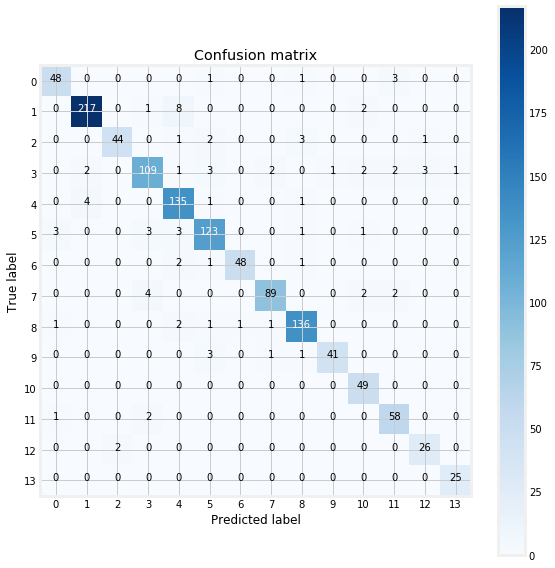

In [389]:
class_names = [i for i in range(14)]
cnf_matrix = confusion_matrix(y_test, predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [390]:
!git add . e-commerce_uk_retailer_machine_learning_analysis.ipynb
!git commit -m "MLP Visualizations for DataSets Periods of Time"
!git push origin master --force

The file will have its original line endings in your working directory


[master be36a5c] MLP Visualizations for DataSets Periods of Time
 1 file changed, 119 insertions(+), 4044 deletions(-)


To https://github.com/kleyersoma/E-Commerce_UK_Retailer_ML
   7c59d06..be36a5c  master -> master
